# Autoregressive Point-Processes as Latent State-Space Models

## Configure notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

# Load scipy/numpy/matplotlib
from   scipy.linalg import expm
import matplotlib.pyplot as plt
from   pylab import *

# Configure figure resolution
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'   ] = 100

from izh       import * # Routines for sampling Izhikevich neurons
from plot      import * # Misc. plotting routines
from glm       import * # GLM fitting
from arppglm   import * # Sampling and integration
from utilities import * # Other utilities
from arguments import * # Argument verification

figure_prefix = "RuleSanguinetti2018_figure_"

import numpy as np

In [2]:
from neurotools.nlab import *

Loading nlab namespace


# Case study: phasic bursting Izhikevich neuron

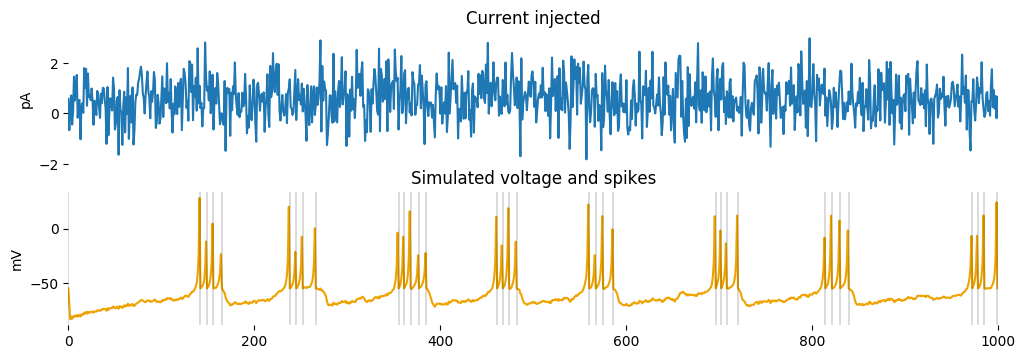

In [3]:
# Izhikevich parameters
izh = (0.02,0.25,-55,0.05) # a, b, c, d
dt  = 1.0

nplot = 1000   # time points for plotting

# Generate constant drive with synaptic noise
I = 0.6
stimulus = randn(nplot)*sqrt(I)+I

# Plot current input
subplot(311); plot(stimulus)
xlim(0,nplot); nox(); noaxis(); ylabel('pA')
title('Current injected')

# Solve Izh model
state = sim_izh(*izh,stimulus)

# Plot voltage and spikes
subplot(312); plot(state[:,1],color=OCHRE);
xlim(0,nplot); noaxis(); addspikes(state[:,-1]); ylabel('mV');
title('Simulated voltage and spikes');

## Train model on pulses

GLMs can emulate neural firing, but have limited ability to generalize outside of the dynamical regime in which they are trained (Weber & Pillow 2017). For this reason, we train with stimuli that elicit phasic bursting responses (tonic bursting seems to be possible at higher stimulation currents, but interferes with the GLMs ability to model the phasic bursting regime).

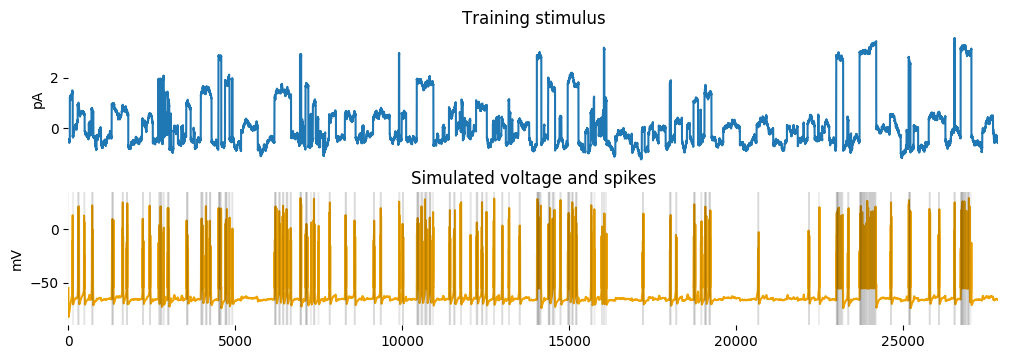

In [6]:
# Define pulse training stimuli
'''
offset     = -1     # Baseline current (picoamps)
min_amp    = 0.3    # Smallest current step (picoamps)
max_amp    = 0.7    # Largest  current step (picoamps)
min_pulse  = 10     # Shortest pulse duration (ms)
max_pulse  = 500    # Longest  pulse duration (ms)
'''

# More challenging
offset     = -0.5     # Baseline current (picoamps)
min_amp    = 0.05    # Smallest current step (picoamps)
max_amp    = 3.0    # Largest  current step (picoamps)
min_pulse  = 10     # Shortest pulse duration (ms)
max_pulse  = 500    # Longest  pulse duration (ms)

amplitudes = exp(linspace(log(min_amp),log(max_amp),10))
durationms = int32(exp(linspace(log(min_pulse),log(max_pulse),10)))
stimulus   = pulse_sequence(amplitudes,durationms,offset)

# Define Ornstein–Uhlenbeck (OU) process training noise 
'''
ssvar     = 0.005          # Noise steady-state viariance (ln(pA)^2)
'''

ssvar     = 0.05          # Noise steady-state viariance (ln(pA)^2)

tau       = 200            # Noise correlation time constant (ms)
noisevar  = 2*ssvar/tau    # Noise fluctuation variance
sigma     = sqrt(noisevar) # Noise flucutation standard deviation
stimulus  += sample_ou_process(0,sigma,tau,dt,len(stimulus),ntrial=1).ravel()

ntrain     = len(stimulus)

# Plot training stimulus
subplot(311); plot(stimulus)
nox(); noaxis(); xlim(0,ntrain); ylabel('pA')
title('Training stimulus');

# Solve Izh model and get voltage and spikes
state = sim_izh(*izh,stimulus,dt=dt)
v,Y   = state[:,1],state[:,2]

# Plot voltage and spikes
subplot(312); plot(v,color=OCHRE); addspikes(Y,lw=0.05);
noaxis(); xlim(0,ntrain); ylabel('mV');
title('Simulated voltage and spikes');

# Fit GLM to Izhikevich model

### Define history basis functions

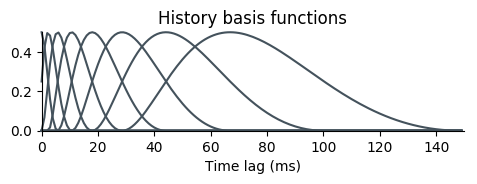

In [7]:
# Define history basis functions
N = 150   # Duration of history filter
K = 8     # number of basis elements
D = 5     # Duration of shortest basis element
B = make_cosine_basis(K,N,D,normalize=False)

# Plot history basis functions
subplot(421)
plot(B.T,color=BLACK,clip_on=False);
xlim(0,N); ylim(0,0.5); simpleaxis()
xlabel('Time lag (ms)')
title('History basis functions')

### Generate stimulus and spiking history training features

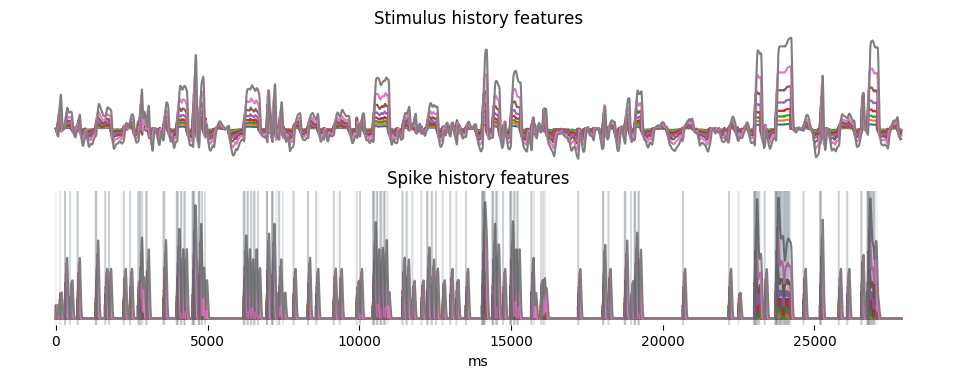

In [8]:
# Build stimulus filter (history trace of I)
# These are needed to model subthreshold dynamics
Bh = array([convolve(b,stimulus) for b in B]).T[:ntrain]
Bp = concatenate([zeros((K,1)),B],axis=1)
By = array([convolve(b,Y) for b in Bp]).T[:ntrain]

# Plot stimulus history features
subplot(311); plot(Bh); noxyaxes();
title('Stimulus history features');

# Plot spike history features
subplot(312); plot(By);
for t in find(Y>0): axvline(t,lw=0.1,color=BLACK)
noaxis(); noy(); xlabel('ms');
title('Spike history features');

## Train model

In [9]:
# Compose feature vector and fit GLM
X = concatenate([By,Bh],axis=1)
m,bhat = fitGLM(X,Y)

bhat_spikehist = bhat[:K]
bhat_stimulus  = bhat[K:]
beta = bhat[:K].reshape(K,1)

### Pulse stimulus for demonstration

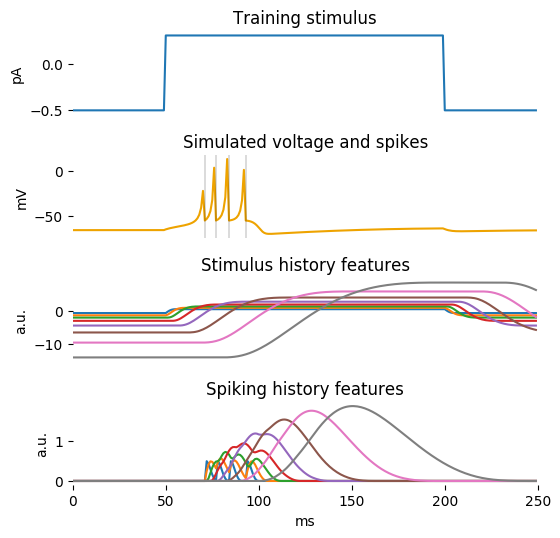

In [10]:
# define demo pulse
duration = 150  # Pulse duration (ms)
padding  = 50   # Pulse padding (ms)
burnin   = 200  # Time for Izhikevich model to settle (ms)
current  = 0.3  # Pulse current (pA)
ndemo    = duration + 2*padding # total length of demo stimulus (ms)

# Build demo stimulus
demo_stimulus = zeros(ndemo+burnin) + offset
demo_stimulus[burnin+padding:burnin+padding+duration] = current

figure(figsize=(6,6))

# Plot demo stimulus
subplot(411); plot(demo_stimulus[burnin:])
nox(); noaxis(); xlim(0,ndemo); ylabel('pA')
title('Training stimulus');

# Solve Izh model
demo_state = sim_izh(*izh,demo_stimulus,dt=dt)
demo_v = demo_state[burnin:,1]
demo_Y = demo_state[burnin:,2]

# Plot demo model spiking 
subplot(412); plot(demo_v,color=OCHRE);
addspikes(demo_Y)
nox(); noaxis(); xlim(0,ndemo); ylabel('mV');
title('Simulated voltage and spikes');

# Bulid GLM filter responses
demo_Bh = array([convolve(b,demo_stimulus) for b in B ]).T[burnin-1:][:ndemo,:]
demo_By = array([convolve(b,demo_Y       ) for b in Bp]).T[:ndemo,:]
demo_X  = concatenate([demo_By,demo_Bh],axis=1)

# Plot demo stimulus history features 
subplot(413); plot(demo_Bh);
xlim(0,ndemo); nox(); noaxis(); ylabel('a.u.')
title('Stimulus history features')

# Plot demo spiking history features 
subplot(414); plot(demo_By);
xlim(0,ndemo); noaxis(); xlabel('ms'); ylabel('a.u.')
title('Spiking history features')
subplots_adjust(hspace=0.5)
plt.draw()

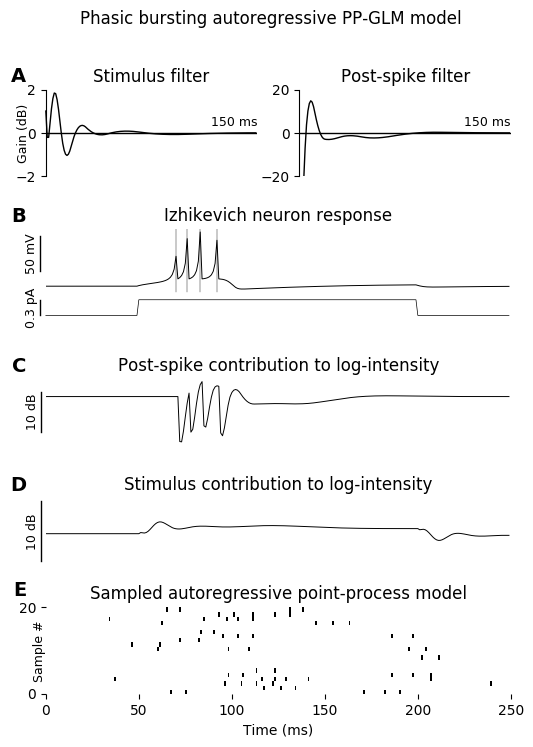

In [11]:
figure(figsize=(6,8))
# Use dB for log-units
dB    = log10(e)*10

def labeltime():
    text(xlim()[1],0+pixels_to_yunits(5),'%d ms'%N,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=9)

# Plot stimulus history filter
stimyscale = 2
a1=subplot2grid((5,2),(0,0),colspan=1)
plot(bhat_stimulus.dot(B)*dB,color='k',lw=1,clip_on=False)
axhline(0,color='k',lw=1)
xlim(0,N); ylim(-stimyscale,stimyscale); nox(); nicey(); simpleraxis();
ylabel('Gain (dB)',fontsize=9); fudgey(10); labeltime()
title('Stimulus filter')
subfigurelabel('A')

# Plot spike history filter
histyscale = 20
a1=subplot2grid((5,2),(0,1),colspan=1)
plot(bhat_spikehist.dot(B)*dB,color='k',lw=1)
axhline(0,color='k',lw=1)
xlim(0,N); ylim(-histyscale,histyscale); nox(); nicey(); simpleraxis(); labeltime()
title('Post-spike filter')

# Illustrate neuron stimulus and response
a2=subplot2grid((5,2),(1,0),colspan=2)
plot(demo_v,'k',lw=0.7)
draw()
yl = ylim()
for t in find(demo_Y)-1:
    plot([t,t],yl,color='k',lw=0.3)
height = abs(diff(yl)*0.25)
lower  = yl[0]-height*1.5
ii     = demo_stimulus[burnin:][:ndemo]
ii     = (ii-min(ii))/(max(ii)-min(ii))
plot(ii*height+lower,color='k',lw=0.5,clip_on=False)
yscalebar(yl[1]-35,50,'50 mV'); 
yscalebar(height*0.5+lower,height,'%0.1f pA'%current)
xlim(0,ndemo); ylim(lower,yl[1]); noxyaxes()
title('Izhikevich neuron response')
subfigurelabel('B')

# Spike history contribution
a3=subplot2grid((5,2),(2,0),colspan=2)
plot(bhat_spikehist.dot(demo_By.T),color='k',lw=0.7)
xlim(0,ndemo); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes()
title('Post-spike contribution to log-intensity')
subfigurelabel('C')

# Stimulus contribution
a4=subplot2grid((5,2),(3,0),colspan=2)
plot(bhat_stimulus.dot(demo_Bh.T),color='k',lw=0.7)
xlim(0,ndemo); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes()
title('Stimulus contribution to log-intensity')
subfigurelabel('D')

# Sample the spiking response of the GLM
a5=subplot2grid((5,2),(4,0),colspan=2)
nsample = 20
stim = m + bhat_stimulus.dot(demo_Bh.T)
ysamp,logratesamp = ensemble_sample(stim,B,beta,nsample)
pcolormesh(1-ysamp.T,cmap="gray")
noaxis(); xticks(arange(0,251,50)); yticks([0,nsample],['0','%s'%nsample])
xlabel('Time (ms)'); ylabel('Sample #',fontsize=9); fudgey(20)
title('Sampled autoregressive point-process model')
subfigurelabel('E',dy=10)

# Make final adjustments
plt.draw()
subplots_adjust(hspace=0.5)
nudge_axis_y(-10,a2); adjust_axis_height_pixels(20,a3); 
nudge_axis_y(-10,a3); adjust_axis_height_pixels(20,a4)
suptitle('Phasic bursting autoregressive PP-GLM model')

savefig(figure_prefix+'1.pdf',transparent=True,bbox_inches='tight')

# Construct low-dimensional system for history process

If the history basis is chosen suitably, the resuling linear system closely approximates the history basis. One can also use a linear system for the history filter form the outset, e.g. a collection of decaying exponential basis functions, enabeling an exact model. Since histor bases are commonly used, and the filtering approach is discussed elsewhere, we demonstrate the low-dimensional delay-line projection here. 

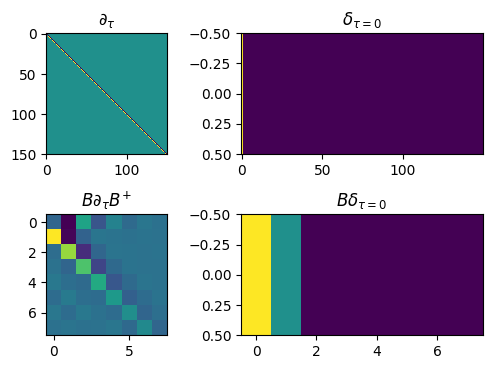

In [12]:
# Create discrete differentiation operator
Dtau = -eye(N) + eye(N,k=-1)
# Create delta operator (to inject signal into delay line)
S = zeros((N,1))
S[0,0] = 1
# Perform a change of basis from function space into the basis projection B
A = B.dot(Dtau).dot(pinv(B))
C = B.dot(S)

figure(figsize=(8,4))
subplot(221); imshow(Dtau)
title('$\partial_\\tau$')
subplot(222); imshow(S.T,aspect=N/2)
title('$\delta_{\\tau=0}$')
subplot(223); imshow(A)
title('$B \partial_\\tau B^{+}$')
subplot(224)
imshow(C.T,aspect=K/2)
title('$B \delta_{\\tau=0}$')
subplots_adjust(hspace=0.5,wspace=-0.3)

# Save model for later use

In [13]:
saved_training_model = {}
saved_training_model['K'] = K
saved_training_model['B'] = B
saved_training_model['By'] = By
saved_training_model['Bh'] = Bh
saved_training_model['A'] = A
saved_training_model['C'] = C
saved_training_model['Y'] = Y 
saved_training_model['dt'] = dt
saved_training_model = scipy.io.savemat('saved_training_model.mat',saved_training_model)

# Illustrate basis projection

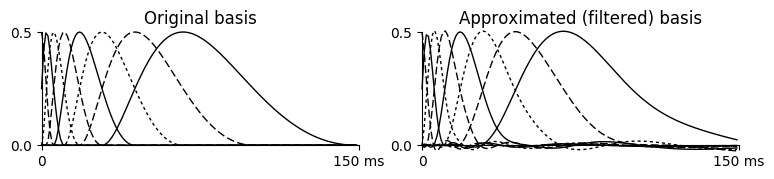

In [14]:
figure(figsize=(9,1.5))
styles = ['--','-',':']

impulse = zeros(N)
impulse[0]=1

subplot(121)
for i,b in enumerate(array([convolve(b,impulse) for b in B])):
    plot(b[:N],lw=1,linestyle=styles[i%len(styles)],color='k',clip_on=False)
simpleaxis(); xlim(0,N); ylim(0,.5); nicexy()
title('Original basis')
xticks([0,150],['0','150 ms'])

filtered = linfilter(A,C,impulse)
subplot(122)
for i,b in enumerate(filtered.T):
    plot(b[:N],lw=1,linestyle=styles[i%len(styles)],color='k',clip_on=False)
simpleaxis(); xlim(0,N); ylim(0,.5); nicexy()
title('Approximated (filtered) basis')
xticks([0,150],['0','150 ms'])

savefig(figure_prefix+'2.pdf',transparent=True,bbox_inches='tight')

# Estimate single-time marginal log-intensity and varience using several different procedures



In [15]:
# "True" sample from point process model
demo_logxpp,demo_logvpp,_,_ = ensemble_sample_moments(stim,B,beta,M=10000)
demo_lxpp = box_filter(demo_logxpp,5)
demo_lvpp = box_filter(demo_logvpp,5)

# Sample from langevin approximation of point process
demo_logxlv,demo_logvlv,_,_  = langevin_sample_moments(stim,A,beta,C,M=10000)
demo_lxlv = box_filter(demo_logxlv,5)
demo_lvlv = box_filter(demo_logvlv,5)

In [16]:
# Estimate moments from mean-field and linear noise approximation
demo_logxmf,demo_logvmf,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "LNA",
                                                int_method = "euler")

# Only first two moments of rate are used for filtering
demo_logxso,demo_logvso,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "second_order",
                                                int_method = "euler")
# Estimate using moment closure
demo_logxmc,demo_logvmc,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "moment_closure",
                                                int_method = "euler")

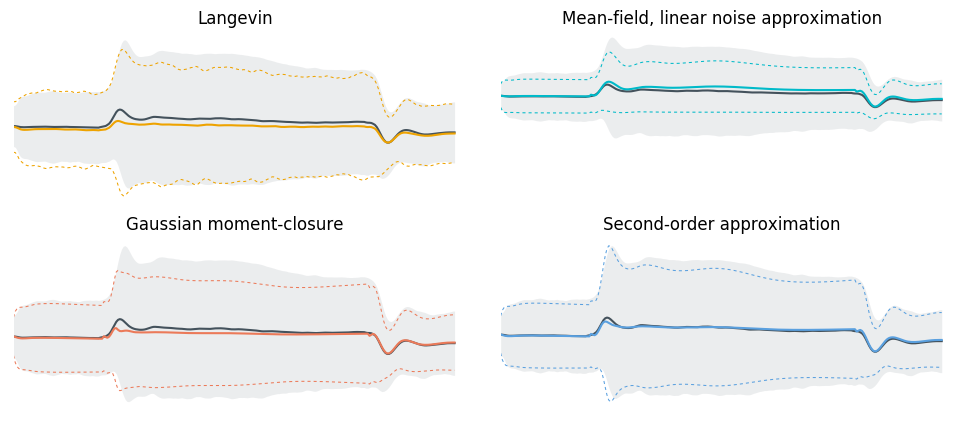

In [17]:
figure(figsize=(12,5))

# Plot sampled point process against sampled Langevin
subplot(221)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_lxlv,demo_lvlv,OCHRE,filled=0)
xlim(0,ndemo); noxyaxes()
title('Langevin')

# Plot LNA against sampled Langevin
subplot(322)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmf,demo_logvmf,TURQUOISE,filled=0)
xlim(0,ndemo); noxyaxes()
title('Mean-field, linear noise approximation')

# Plot moment-closure against sampled Langevin
subplot(223)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmc,demo_logvmc,RUST,filled=0)
xlim(0,ndemo); noy(); noxyaxes()
title('Gaussian moment-closure')

# Plot second-order against sampled Langevin
# This amounts to moment closure, where the GLM nonlinearity
# is locally approximated as a quadratic function. The log-
# Gaussian distribution on the rates is, in genral, too right
# skewed, and over-estimates the probability of high rates. 
# The quadratic approximation removes the effects of higher
# order moments, attenuating this heavy tail and leading to
# a moment closure that is less stiff to integrate and more
# accurately captures the second moment.
subplot(224)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxso,demo_logvso, AZURE,filled=0)
xlim(0,ndemo); noy(); noxyaxes();
title('Second-order approximation')


subplots_adjust(wspace=0.1,hspace=0.2)

# Demonstration pulse sequence

Construct a more "naturalistic" intput stimulus

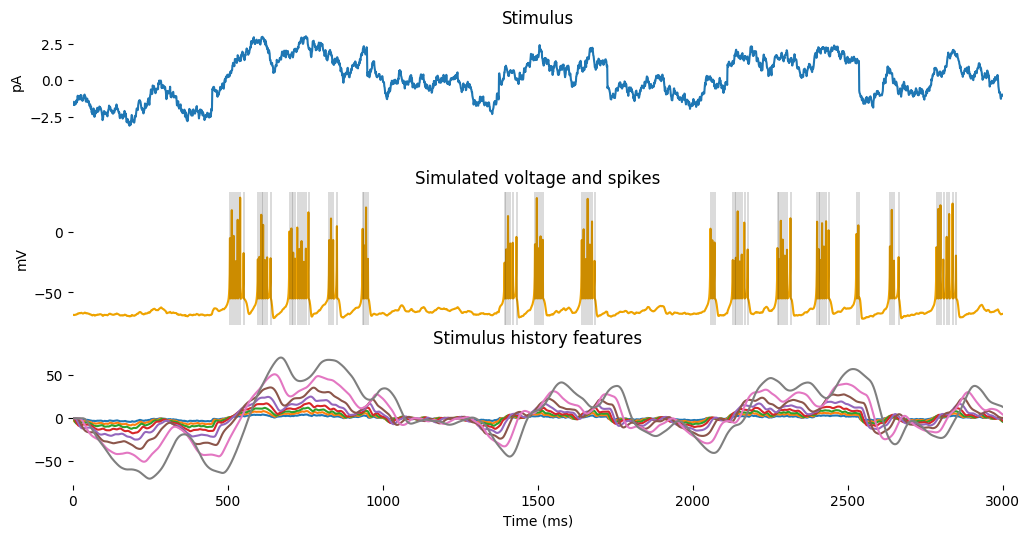

In [18]:
NSTIM    = 3000

# Random pulse sequence
offset     = -0.5
pulse_stimulus = pulse_sequence(linspace(0.5,1.0,5),int32(linspace(50,500,7)),offset)

# OU process defining additional Gaussian noise
ntrain = len(pulse_stimulus)
ssvar    = 1
tau      = 100
noisevar = 2*ssvar/tau
sigma    = sqrt(noisevar)
noise2   = sample_ou_process(0,sigma,tau,dt,ntrain,ntrial=1).ravel()

# Combine pulses with noise, apply synaptic filter
stimulus = pulse_stimulus + noise2
stimulus = stimulus[:NSTIM*2]

# Plot
subplot(411); plot(stimulus[NSTIM:])
xlim(0,NSTIM); ylabel('pA'); noaxis(); nox()
title('Stimulus')

# Solve Izh model
state = sim_izh(*izh,stimulus,dt=dt)
V     = state[:,1][NSTIM:]
Y     = state[:,2][NSTIM:]
subplot(312); plot(V,color=OCHRE);
addspikes(Y)
xlim(0,NSTIM); noaxis(); nox()
title('Simulated voltage and spikes');
ylabel('mV');

stimulus = stimulus[NSTIM:]

# Build stimulus filter (history trace of I)
# These are needed to model subthreshold dynamics
demo_Bh = array([convolve(b,stimulus) for b in B ]).T[:NSTIM]
demo_By = array([convolve(b,Y)        for b in Bp]).T[:NSTIM,:]

# Plot stimulus history features
subplot(313); plot(demo_Bh); 
xlim(0,NSTIM); noaxis(); xlabel('Time (ms)')
title('Stimulus history features')

# Demonstrate moment-closure approximation of the AR-PP-GLM

In [19]:
# Filtered stimulus with offset
stim = m + bhat_stimulus.dot(demo_Bh.T)

# "True" sample from point process model
logxpp,logvpp,ratepp,ratevpp = ensemble_sample_moments(stim,B,beta,M=1000)
lxpp = box_filter(logxpp,5)
lvpp = box_filter(logvpp,5)

# Sample from langevin approximation of point process
logxlv,logvlv,expmlv,expvlv  = langevin_sample_moments(stim,A,beta,C,M=5000)
lxlv = box_filter(logxlv,5)
lvlv = box_filter(logvlv,5)

# Estimate moments from expansion to second order 
# Only first two moments of rate are used for filtering
logxso,logvso,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "second_order",
                                            int_method = "exponential",
                                            oversample = 3)

logxmc,logvmc,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "moment_closure",
                                            int_method = "euler",
                                            oversample = 5)

logxmf,logvmf,_,_ = integrate_moments(stim,A,beta,C,
                                            method     = "LNA",
                                            int_method = "euler",
                                            oversample = 5)

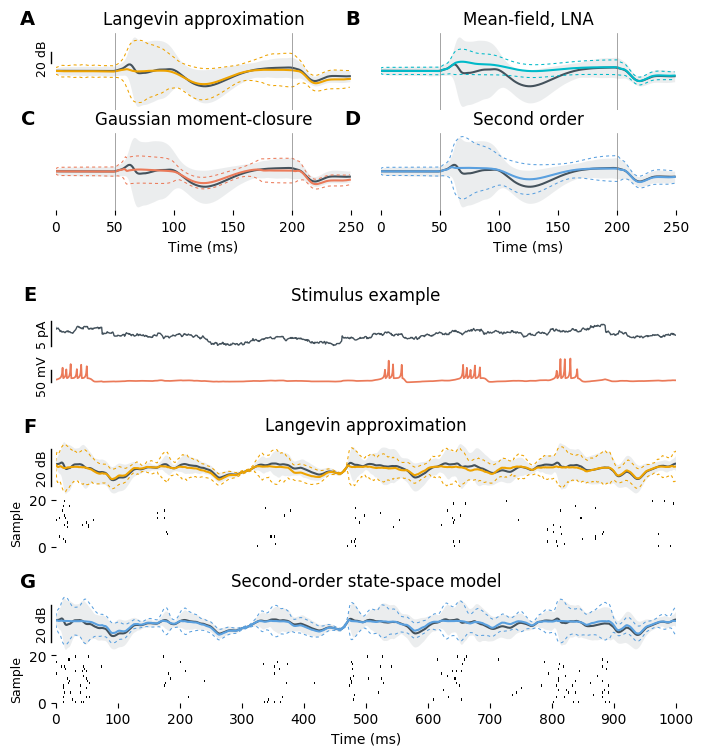

In [18]:
figure(figsize=(8,13))
NROWS = 10
NPLOT = 3000
NSHOW = 1000

def stimmarks():
    axvline(padding,color=(0.5,)*3,lw=0.5)
    axvline(ndemo-padding,color=(0.5,)*3,lw=0.5)

# Plot second-order approximation
subplot2grid((NROWS,2),(1,1),facecolor=(1,1,1,0))
stderrplot(demo_lxpp  ,demo_lvpp  ,BLACK    ,filled=1)
stderrplot(demo_logxso,demo_logvso,AZURE,filled=0)
stimmarks(); xlim(0,ndemo); noy(); noaxis()
yl = ylim()
xlabel('Time (ms)')
title('Second order')
subfigurelabel('D')
    
# Plot true sampled GLM against Langevin sampled GLM
subplot2grid((NROWS,2),(0,0),facecolor=(1,1,1,0))
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_lxlv,demo_lvlv,OCHRE,filled=0)
stimmarks(); ylim(*yl); xlim(0,ndemo); noxyaxes()
yscalebar(mean(ylim())/dB,20/dB,'20 dB'); 
title('Langevin approximation')
subfigurelabel('A')

# Plot mean-field LNA solution for moments
subplot2grid((NROWS,2),(0,1),facecolor=(1,1,1,0))
stderrplot(demo_lxpp  ,demo_lvpp  ,BLACK,filled=1)
stderrplot(demo_logxmf,demo_logvmf,TURQUOISE,filled=0)
stimmarks(); ylim(*yl); xlim(0,ndemo); noxyaxes(); simpleraxis()
title('Mean-field, LNA')
subfigurelabel('B')

# Plot moment closure moments
subplot2grid((NROWS,2),(1,0),facecolor=(1,1,1,0))
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmc,demo_logvmc,RUST,filled=0)
stimmarks(); ylim(*yl); xlim(0,ndemo); noy(); noaxis()
xlabel('Time (ms)')
title('Gaussian moment-closure')
subfigurelabel('C')

# Plot Izh neuron
sc = 20
ax4=subplot2grid((NROWS,2),(2,0),colspan=2,facecolor=(1,1,1,0))
plot(V,color=RUST,lw=1.25)
xlim(0,NSHOW);
yscalebar(min(V)+25,50,'50 mV')
offset = -min(stimulus*sc) + ylim()[1]+30
ss = stimulus*sc + offset
plot(ss,color=BLACK,lw=1)
yscalebar(mean(ss),sc*5,'5 pA'); 
noxyaxes()
title('Stimulus example')
subfigurelabel('E')

# Plot stimulus
ax5=subplot2grid((NROWS,2),(3,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
# Langevin approximation
stderrplot(logxlv,logvlv,OCHRE,filled=0)
xlim(0,NSHOW); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Langevin approximation')
subfigurelabel('F')

# Plot sampled from Langevin (preserves some autocorrelation)
ax6=subplot2grid((NROWS,2),(4,0),colspan=2,facecolor=(1,1,1,0))
nsamp = 20
p = np.random.poisson(exp(langevin_sample(stim,A,beta,C,M=nsamp)))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); nox(); xlim(0,NSHOW);
ylabel('Sample',fontsize=9);

# Plot stimulus
ax7=subplot2grid((NROWS,2),(5,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(logxso,logvso,AZURE,filled=0)
xlim(0,NSHOW); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Second-order state-space model')
subfigurelabel('G')

# Plot sampled from single-time marginals (no time correlation)
ax8=subplot2grid((NROWS,2),(6,0),colspan=2,facecolor=(1,1,1,0))
rate = exp(logxso)*(1+0.5*logvso)
p = np.random.poisson(rate[:,None],(len(rate),nsamp))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); xticks(arange(0,1001,100)); xlim(0,NSHOW);
xlabel('Time (ms)'); ylabel('Sample',fontsize=9); 

# Adjust axes
subplots_adjust(wspace=0.1,hspace=0.3)
nudge_axis_y(-75,ax4)
adjust_axis_height_pixels(20,ax5)
nudge_axis_y(-85,ax5)
adjust_axis_height_pixels(30,ax6)
nudge_axis_y(-35,ax6)
adjust_axis_height_pixels(20,ax7)
nudge_axis_y(-40,ax7)
adjust_axis_height_pixels(30,ax8)
nudge_axis_y(10,ax8)

savefig(figure_prefix+'4.pdf',transparent=True,bbox_inches='tight',format='pdf')

# Measurement, filtering, and inference

In [19]:
NFILT = NPLOT#200
#assert(NFILT<=NPLOT)

from measurements import *
from arppglm import *

## Test different updates (variational, Laplace, moment-matching)

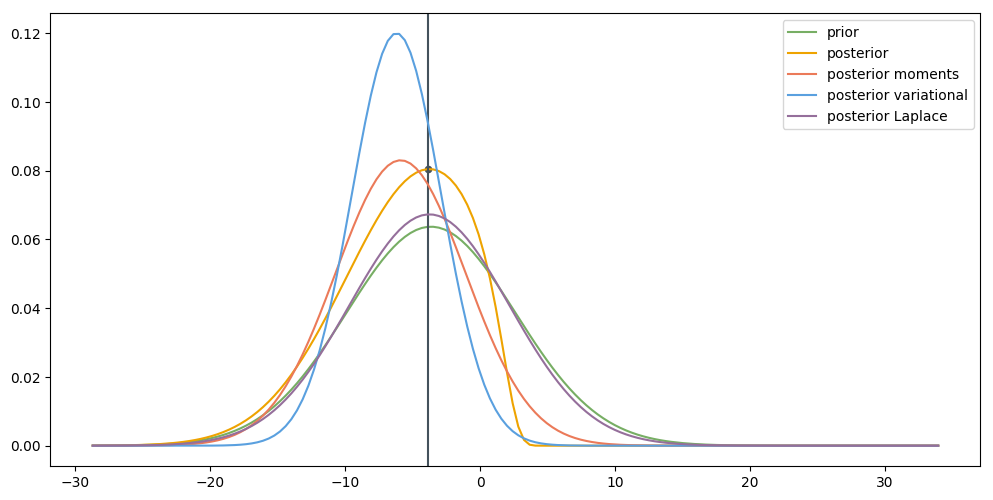

In [20]:
logxso,logvso,M1,M2 = integrate_moments(stim,A,beta,C,
                                        method     = "second_order",
                                        int_method = "exponential",
                                        oversample = 3)

t = find(Y>0)[0]
m1 = M1[t]
m2 = M2[t]
s  = stim[t]
y  = Y[i]

# Plot Prior
v  = beta.T.dot(m2).dot(beta)[0,0]
mu = beta.T.dot(m1)
ss = sqrt(v)
x = np.linspace(mu-4*ss,mu+6*ss,150)
plot(x,npdf(mu,v**0.5,x).ravel(),color=GREEN,label='prior')

# posterior, exact
l = y*(x+s)-sexp(x+s)
l-= np.max(l)
l+=-.5*(x-mu)**2/v-.5*slog(v) 
p = sexp(l)
eps = 1e-12
p[p<eps] = eps   
p = (p/np.sum(p)).ravel()
plot(x,p/diff(x)[0],color=OCHRE,label='posterior')
pmode = argmax(p)
scatter([x[pmode]],[p[pmode]/diff(x)[0]],s=20,color=BLACK)
axvline(x[pmode],color=BLACK)

# Posterior moments
mp,vp = univariate_lgp_update_moment(mu,v,y,s,1.0)
l = -.5*(x-mp)**2/vp-.5*slog(vp) 
p = sexp(l-np.max(l))
eps = 1e-12
p[p<eps] = eps   
p /= np.sum(p)
plot(x,p/diff(x)[0],color=RUST,label='posterior moments')

# Posterior moments
mp,vp = univariate_lgp_update_variational(mu,v,y,s,1.0)
l = -.5*(x-mp)**2/vp-.5*slog(vp) 
p = sexp(l-np.max(l))
eps = 1e-12
p[p<eps] = eps   
p /= np.sum(p)
plot(x,p/diff(x)[0],color=AZURE,label='posterior variational')

# Posterior moments
mp,vp = univariate_lgp_update_laplace(mu,v,y,s,1.0)
l = -.5*(x-mp)**2/vp-.5*slog(vp) 
p = sexp(l-np.max(l))
eps = 1e-12
p[p<eps] = eps   
p /= np.sum(p)
plot(x,p/diff(x)[0],color=MAUVE,label='posterior Laplace')

legend()

# Benchmark different measurement updates

In [21]:
m = -5.1

t=5908424ms 
dt=4938ms 
26123842881.9
t=4984ms 
dt=11750ms 
nan
t=11785ms 
dt=1671ms 
0.144028348448
t=1710ms 
dt=332ms 


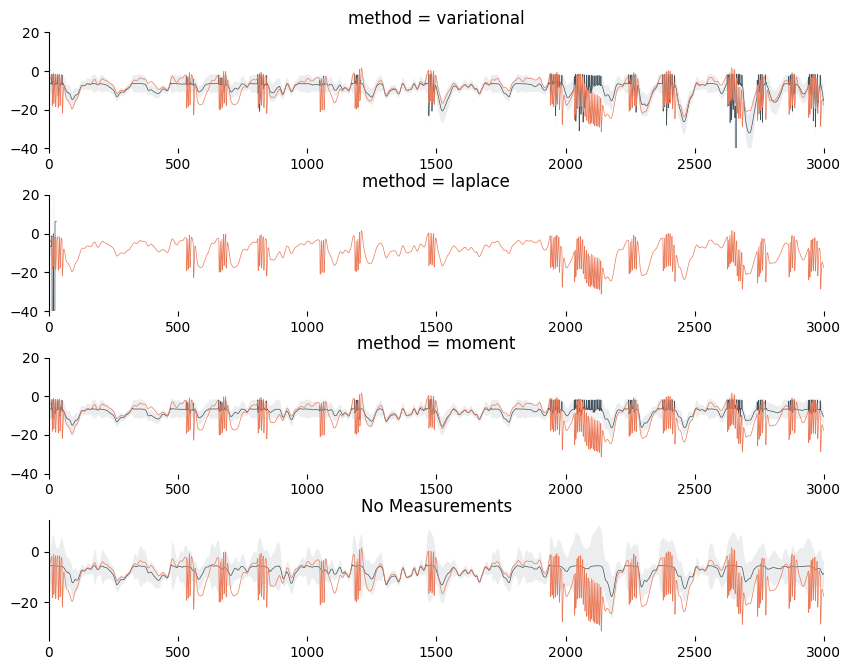

In [34]:
figure(figsize=(10,8))

for i,measurement in enumerate("variational laplace moment".split()):
    tic()
    fallLR,fallLV,fallM1,fallM2,nll = filter_moments(stim[:NFILT],Y[:NFILT],A,beta,C,m,
                                         method      = "moment_closure",
                                         int_method  = "euler",
                                         measurement = measurement,
                                         oversample  = 25,
                                         reg_cov     = 0.0001,
                                         reg_rate    = 0.0000)
    toc()
    print(nll)
    subplot(4,1,i+1)
    logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
    stderrplot(fallLR,fallLV,BLACK,filled=1,lw=0.5)
    xlim(0,NFILT);
    plot(logr,color=RUST,lw=0.5)
    simpleraxis()
    title('method = %s'%measurement)
    ylim(-40,20)

# Compare to moment integration without filtering
subplot(4,1,i+1)
tic()
fallLR,fallLV,fallM1,fallM2 = integrate_moments(stim[:NFILT],A,beta,C,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 4)
toc()
subplot(4,1,4)
logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
stderrplot(fallLR,fallLV,BLACK,filled=1,lw=0.5)
xlim(0,NFILT);
plot(logr,color=RUST,lw=0.5)
simpleraxis()
title('No Measurements')

subplots_adjust(hspace=0.4)

## Optimize model likelihood using filtering (new model)

In [23]:
measurement = "moment"
method      = "moment_closure"
int_method  = "euler"
oversample  = 25
showplot    = False

baseline_m = m

#@memoize
def objective(parameters):
    # parameters encode beta,m
    parameters = parameters.ravel()
    m          = parameters[0]
    beta       = parameters[1:].reshape((K,1))
    stim2      = stim[:NFILT]*exp(m-baseline_m)
    
    # We need unconstrained system to also be stable!
    '''
    try:
        LR,LV,M1,M2 = integrate_moments(stim2,A,beta,C,
                                        method     = method,
                                        int_method = int_method,
                                        oversample = oversample)
        # Ensure moments do not diverge
        rate = exp(LR)*(1+0.5*LV)
        if not all([np.all(np.isfinite(x)) for x in [LR,LV,M1,M2,rate]]): 
            return inf
    except (KeyboardInterrupt, SystemExit): raise
    except: return inf
    '''
    
    # Get likelihood by filtering
    try:
        LR,LV,M1,M2,nll = filter_moments(stim2,Y[:NFILT],A,beta,C,m,
                                         method      = method,
                                         int_method  = int_method,
                                         measurement = measurement,
                                         oversample  = oversample,
                                         reg_cov     = 0.005,
                                         reg_rate    = 0.005)
    except (KeyboardInterrupt, SystemExit): raise
    except: 
        return inf
    
    print(nll,'['+','.join(['%0.6f'%x for x in parameters])+']')
    if showplot:
        subplot(311)
        logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
        stderrplot(fallLR,fallLV,BLACK,filled=1,lw=0.5)
        xlim(0,NFILT);
        plot(logr,color=RUST,lw=0.5)
        simpleraxis()
        show()
    
    if not np.isfinite(nll):
        return inf
    return nll

p0 = np.zeros((1+K))
p0[0 ] = m
p0[1:] = beta.ravel()

# Some previous optimization results; might want to start here 
p0 = [-5.11891304,7.73303371,-17.66706182,14.49299672,-8.02784155,4.92439071,-3.49133731,1.31580891,-0.97790629]
#0.131838411542 [-5.11891304,7.73303371,-17.66706182,14.49299672,-8.02784155,4.92439071,-3.49133731,1.31580891,-0.97790629]
#p0 = [-4.996745,7.716718,-18.654041,16.607897,-9.931949,5.929623,-4.022354,1.269709,-0.802766]
#p0 = [-5.24983774,7.23237526,-19.34798948,17.00141048,-10.14977969,6.26055667,-4.32966734,1.40397708,-0.89879142]
#p0 = [-5.266607,7.152043,-19.402685,17.013701,-10.152928,6.284366,-4.369510,1.391431,-0.872793]
#0.0820119611644 [-5.2695,7.0807,-19.4337,17.0858,-10.0722,6.3919,-4.3904,1.3321,-0.9087]
#p0 = [-5.2695,7.0807,-19.4337,17.0858,-10.0722,6.3919,-4.3904,1.3321,-0.9087]
#p0  = [-6.8267,-14.5113,-12.2582,19.8257,-11.3998,9.4435,-4.5493,-0.8425,0.1381]
#p0 = [-6.8034,-14.4812,-12.2502,19.8148,-11.4017,9.4339,-4.5452,-0.8094,0.1385]
#p0 = [-6.8034,-14.5821,-12.4526,19.5295,-11.7096,9.0415,-4.9698,-1.2497,-0.5224]
#p0 = [-6.8034,-14.5827,-12.4544,19.5262,-11.4234,9.3272,-4.9632,-1.7242,-1.3170]
#p0 = [-6.5234,-16.2560,-12.9578,19.2764,-10.9165,9.2419,-4.7980,-1.7083,-1.2991]
#p0 = [-6.7323,-16.3787,-12.8744,19.2316,-11.1853,8.9326,-4.8782,-1.8222,-1.2926]
#p0 = [-6.7324,-16.3787,-12.8744,19.2314,-11.1853,8.9325,-4.8782,-1.8223,-1.2927]
#p0 = [-6.4118,-16.3787,-12.8744,19.2314,-11.1853,8.9325,-4.8782,-1.8223,-1.2927]
#p0 = [-5.9985,-18.8823,-12.7941,19.2112,-10.6532,8.0912,-4.7045,-2.1577,-1.2712]

parameters = minimize_retry(objective,p0)
nll = objective(parameters)
print(nll,'['+','.join(['%0.8f'%x for x in parameters])+']')

0.137573274868 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274868 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274901 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274872 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274857 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274873 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274851 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.13757327483 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274799 [-5.118913,7.733034,-17.667062,14.492997,-8.027842,4.924391,-3.491337,1.315809,-0.977906]
0.137573274846 [-5.118913,7.733034,-17.667062,14.492997,

0.136434943534 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943487 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943537 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943529 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943552 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943546 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.13643494354 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943521 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943565 [-5.185446,7.718765,-17.634715,14.470677,-7.987561,5.027762,-3.292076,1.363322,-0.834035]
0.136434943519 [-5.185446,7.718765,-17.634715,14.470677,

0.135516770729 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770716 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770731 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770719 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770713 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770699 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770743 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135516770695 [-5.071310,7.698379,-17.581486,14.338997,-8.057111,5.012264,-3.160154,1.108728,-0.681052]
0.135083842751 [-5.062415,7.685566,-17.541582,14.247254,-8.105814,4.997167,-3.078670,0.911496,-0.574454]
0.135083842751 [-5.062415,7.685566,-17.541582,14.247254

0.133422094206 [-5.044316,7.634140,-17.371153,13.948061,-8.198403,5.077233,-2.585809,0.359525,-0.118401]
0.133422094197 [-5.044316,7.634140,-17.371153,13.948061,-8.198403,5.077233,-2.585809,0.359525,-0.118401]
0.133422094202 [-5.044316,7.634140,-17.371153,13.948061,-8.198403,5.077233,-2.585809,0.359525,-0.118401]
0.133422094196 [-5.044316,7.634140,-17.371153,13.948061,-8.198403,5.077233,-2.585809,0.359525,-0.118401]
0.133422094253 [-5.044316,7.634140,-17.371153,13.948061,-8.198403,5.077233,-2.585809,0.359525,-0.118401]
0.133422094276 [-5.044316,7.634140,-17.371153,13.948061,-8.198403,5.077233,-2.585809,0.359525,-0.118401]
0.133219915699 [-5.044454,7.634016,-17.346610,13.931074,-8.194025,5.094215,-2.532577,0.306341,-0.107397]
0.133219915699 [-5.044454,7.634016,-17.346610,13.931074,-8.194025,5.094215,-2.532577,0.306341,-0.107397]
0.133219915685 [-5.044454,7.634016,-17.346610,13.931074,-8.194025,5.094215,-2.532577,0.306341,-0.107397]
0.133219915689 [-5.044454,7.634016,-17.346610,13.931074

0.131963432855 [-4.970007,7.622066,-17.035923,13.644225,-8.207845,5.243409,-1.878018,-0.479326,0.110514]
0.13196343283 [-4.970007,7.622066,-17.035923,13.644225,-8.207845,5.243409,-1.878018,-0.479326,0.110514]
0.131963432828 [-4.970007,7.622066,-17.035923,13.644225,-8.207845,5.243409,-1.878018,-0.479326,0.110514]
0.13196343284 [-4.970007,7.622066,-17.035923,13.644225,-8.207845,5.243409,-1.878018,-0.479326,0.110514]
0.131947907299 [-4.972011,7.624494,-17.026947,13.639946,-8.207712,5.240318,-1.865453,-0.482724,0.109967]
0.131947907299 [-4.972011,7.624494,-17.026947,13.639946,-8.207712,5.240318,-1.865453,-0.482724,0.109967]
0.131947907292 [-4.972011,7.624494,-17.026947,13.639946,-8.207712,5.240318,-1.865453,-0.482724,0.109967]
0.131947907294 [-4.972011,7.624494,-17.026947,13.639946,-8.207712,5.240318,-1.865453,-0.482724,0.109967]
0.131947907288 [-4.972011,7.624494,-17.026947,13.639946,-8.207712,5.240318,-1.865453,-0.482724,0.109967]
0.131947907308 [-4.972011,7.624494,-17.026947,13.639946,-

0.131163754883 [-5.038813,7.819856,-16.376324,13.245329,-8.329629,4.775041,-1.114648,-0.734729,0.110725]
0.131163754862 [-5.038813,7.819856,-16.376324,13.245329,-8.329629,4.775041,-1.114648,-0.734729,0.110725]
0.130968873016 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968873016 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968872969 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968873007 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968873004 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968873016 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968873008 [-5.030150,7.870444,-16.210939,13.131064,-8.377747,4.629227,-0.941927,-0.811314,0.124757]
0.130968873043 [-5.030150,7.870444,-16.210939,13.131064

0.130508565461 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565461 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565488 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565446 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.13050856544 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565445 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565423 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.13050856544 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565441 [-4.997961,7.944195,-16.200656,13.251778,-8.281404,4.502734,-1.241407,-0.638705,0.104635]
0.130508565445 [-4.997961,7.944195,-16.200656,13.251778,-

0.129174028673 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028673 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028703 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028513 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028605 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.12917402866 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028598 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028569 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028556 [-4.978279,8.335497,-15.520115,13.277075,-7.982562,3.908363,-1.254401,-0.493743,0.094586]
0.129174028585 [-4.978279,8.335497,-15.520115,13.277075,

nan [-4.991533,8.349567,-15.529284,13.212551,-7.920245,3.930239,-1.262302,-0.496956,0.095265]
0.129440939549 [-5.001586,8.319226,-15.572509,13.261987,-7.959111,3.907229,-1.261089,-0.496479,0.095174]
nan [-5.002030,8.327820,-15.454871,13.202203,-7.932374,3.926363,-1.264041,-0.497641,0.095396]
0.129403418131 [-4.997312,8.328513,-15.597604,13.263502,-7.952934,3.909684,-1.260512,-0.496251,0.095130]
0.12909959393 [-5.023802,8.318342,-15.599443,13.206276,-7.903756,3.924264,-1.232566,-0.500333,0.095913]
0.129040901264 [-5.046597,8.309285,-15.640042,13.170971,-7.864655,3.932969,-1.206197,-0.503665,0.096551]
0.128913907651 [-5.010430,8.333364,-15.560186,13.200952,-7.905611,3.929608,-1.244580,-0.499121,0.095680]
0.12860704823 [-5.014852,8.340433,-15.554024,13.170434,-7.878861,3.940798,-1.236326,-0.500442,0.095934]
0.129076681455 [-4.956729,8.325184,-15.586379,13.158914,-7.881257,3.936108,-1.243362,-0.501689,0.096173]
0.128676081987 [-4.998334,8.325705,-15.533998,13.151905,-7.876841,3.940310,-1.2

nan [-5.014564,8.396937,-15.711255,12.887558,-7.531854,3.926848,-1.194335,-0.511026,0.099653]
0.127964347389 [-5.031502,8.375620,-15.703342,12.806265,-7.558964,3.959790,-1.194826,-0.512760,0.098766]
0.127797658888 [-5.027439,8.406130,-15.770314,12.691885,-7.434182,3.941849,-1.197092,-0.514926,0.099886]
0.127742451198 [-5.028364,8.428053,-15.829040,12.565733,-7.328138,3.934523,-1.199285,-0.517367,0.100663]
0.127832988677 [-5.037502,8.415574,-15.815158,12.681920,-7.369329,3.927182,-1.172006,-0.518800,0.100818]
0.12773774898 [-5.025192,8.415349,-15.784868,12.731556,-7.409714,3.924651,-1.186534,-0.515586,0.100502]
0.136270331266 [-5.022038,8.435213,-15.825632,12.694201,-7.335089,3.907081,-1.182389,-0.516999,0.101371]
0.127732234585 [-5.021330,8.418119,-15.795029,12.684680,-7.412669,3.928315,-1.177162,-0.520081,0.100361]
0.127672335083 [-5.015238,8.436890,-15.837617,12.611504,-7.354298,3.917271,-1.165249,-0.525324,0.100943]
0.127645296473 [-5.030245,8.441268,-15.814636,12.713509,-7.387485,3

0.127318838819 [-5.032926,8.620746,-16.172012,12.190537,-6.665796,3.757658,-1.257780,-0.511018,0.105166]
0.127376914356 [-5.055565,8.648654,-16.202062,12.147557,-6.713834,3.726368,-1.228075,-0.513458,0.105044]
0.127314190738 [-5.015536,8.560310,-16.040421,12.323689,-6.935928,3.813802,-1.238630,-0.514153,0.103251]
nan [-5.026846,8.586095,-16.062746,12.290081,-6.883594,3.786765,-1.266846,-0.504081,0.103184]
0.127323421075 [-5.027798,8.587074,-16.098428,12.263856,-6.864102,3.787865,-1.224052,-0.517531,0.104009]
nan [-5.020651,8.572348,-16.052222,12.317671,-6.921468,3.803442,-1.239916,-0.508959,0.103575]
0.127319771662 [-5.030008,8.592028,-16.100633,12.255016,-6.851216,3.781751,-1.235790,-0.515146,0.103829]
0.127351430819 [-5.036017,8.536884,-15.999617,12.420452,-7.020245,3.826002,-1.209302,-0.518535,0.102803]
0.127307117627 [-5.023995,8.604030,-16.117562,12.220489,-6.818490,3.774533,-1.247110,-0.511383,0.104099]
0.127280202694 [-5.027361,8.579990,-16.062318,12.300793,-6.897246,3.792551,-1

0.127064939944 [-5.028615,8.718128,-16.273395,12.275146,-6.638919,3.619184,-1.258182,-0.505353,0.105270]
0.127101512078 [-5.017596,8.693446,-16.246782,12.289221,-6.639816,3.649830,-1.262284,-0.505709,0.105249]
0.127082895561 [-5.025367,8.649792,-16.159798,12.386270,-6.774695,3.686793,-1.260527,-0.503573,0.104275]
nan [-5.018967,8.674885,-16.213507,12.295657,-6.698478,3.670238,-1.257690,-0.506484,0.104891]
0.12709907709 [-5.029235,8.688933,-16.236091,12.269604,-6.639217,3.661082,-1.273579,-0.501433,0.105096]
0.127050476369 [-5.030462,8.681213,-16.215125,12.346117,-6.732895,3.653528,-1.241329,-0.505590,0.104759]
0.135668681278 [-5.034378,8.678027,-16.202224,12.408570,-6.801894,3.644163,-1.216345,-0.507991,0.104507]
0.127089749129 [-5.030789,8.690002,-16.224111,12.367853,-6.717318,3.636154,-1.247289,-0.505194,0.104839]
nan [-5.026168,8.653439,-16.166117,12.402004,-6.799424,3.676748,-1.243211,-0.509574,0.104176]
0.127087248309 [-5.028172,8.696692,-16.248128,12.268473,-6.635556,3.650179,-1.

0.12701017973 [-5.027535,8.671273,-16.178485,12.521981,-6.895455,3.624136,-1.187442,-0.515405,0.104207]
0.127009946292 [-5.028384,8.702418,-16.229866,12.471968,-6.836377,3.593537,-1.185559,-0.516267,0.104633]
0.127007299451 [-5.027922,8.687466,-16.199660,12.532023,-6.899662,3.599219,-1.174648,-0.518214,0.104314]
0.127024885706 [-5.030097,8.715400,-16.246384,12.470082,-6.830343,3.576216,-1.181942,-0.517632,0.104699]
0.127009101237 [-5.026711,8.679548,-16.194501,12.486479,-6.856883,3.621097,-1.197175,-0.514166,0.104388]
0.127007201764 [-5.028630,8.676100,-16.190394,12.508930,-6.881838,3.620421,-1.182353,-0.515608,0.104352]
0.127007607035 [-5.029064,8.684659,-16.207317,12.457793,-6.833973,3.621153,-1.196726,-0.513483,0.104532]
0.12700027956 [-5.028528,8.703811,-16.236336,12.468413,-6.833362,3.591048,-1.177909,-0.517695,0.104759]
0.127001266489 [-5.028913,8.718944,-16.263332,12.456687,-6.817236,3.572008,-1.165254,-0.520188,0.105020]
0.135668583963 [-5.028490,8.681466,-16.195866,12.524150,-

0.126991130111 [-5.029875,8.703706,-16.240290,12.505556,-6.872837,3.580658,-1.145101,-0.522290,0.104838]
0.126992091095 [-5.030407,8.696800,-16.229678,12.518120,-6.888488,3.587286,-1.142087,-0.522134,0.104757]
0.126990527037 [-5.030384,8.702388,-16.240212,12.499691,-6.869378,3.583634,-1.144848,-0.522122,0.104863]
0.126993150705 [-5.030809,8.706223,-16.244244,12.513829,-6.882746,3.574891,-1.135932,-0.523689,0.104863]
0.126991322824 [-5.030948,8.702991,-16.241491,12.501675,-6.871120,3.582488,-1.142302,-0.522226,0.104874]
0.126992356199 [-5.031516,8.712713,-16.257765,12.489679,-6.857644,3.571560,-1.138318,-0.523313,0.105010]
0.126991220844 [-5.030685,8.700778,-16.236700,12.511009,-6.880777,3.583354,-1.141144,-0.522429,0.104820]
0.126990323748 [-5.030161,8.699793,-16.235050,12.514710,-6.884033,3.583416,-1.140573,-0.522836,0.104812]
0.126990622688 [-5.029459,8.695642,-16.227805,12.523892,-6.893301,3.586689,-1.140825,-0.522964,0.104753]
0.126990323874 [-5.030138,8.699225,-16.234073,12.520290

0.126984212102 [-5.021997,8.714377,-16.274119,12.516904,-6.869058,3.555431,-1.106128,-0.531969,0.105449]
0.126983650059 [-5.021753,8.714181,-16.274331,12.502166,-6.853625,3.559600,-1.115400,-0.530544,0.105461]
0.126983634941 [-5.020710,8.713837,-16.273984,12.508397,-6.857524,3.558040,-1.113322,-0.531297,0.105475]
0.126984123103 [-5.023350,8.711726,-16.270046,12.510362,-6.865186,3.561410,-1.111063,-0.530504,0.105407]
0.126983681309 [-5.022050,8.710917,-16.268559,12.502966,-6.856103,3.564195,-1.118448,-0.529838,0.105404]
0.12698425411 [-5.021689,8.715460,-16.276231,12.487765,-6.839677,3.561699,-1.122971,-0.529398,0.105471]
0.12698383879 [-5.022935,8.712659,-16.271592,12.504713,-6.858809,3.561483,-1.114040,-0.530227,0.105423]
0.126983721121 [-5.020708,8.713415,-16.274442,12.502037,-6.852158,3.560050,-1.114906,-0.530953,0.105494]
0.126983880945 [-5.021776,8.718177,-16.282533,12.492910,-6.842740,3.556004,-1.114179,-0.530812,0.105559]
0.126984176839 [-5.020770,8.714675,-16.278183,12.510910,-

0.126982586867 [-5.021140,8.712762,-16.269331,12.516428,-6.862433,3.557816,-1.116406,-0.530992,0.105407]
0.126982443335 [-5.021287,8.712353,-16.268924,12.517128,-6.863281,3.558045,-1.115783,-0.531114,0.105407]
0.126982684 [-5.020442,8.711357,-16.267148,12.514848,-6.859902,3.560089,-1.119710,-0.530629,0.105398]
0.126982553457 [-5.021113,8.712940,-16.269209,12.514584,-6.860048,3.558211,-1.118378,-0.530650,0.105401]
0.12698248612 [-5.020658,8.712814,-16.269456,12.517903,-6.862351,3.557040,-1.116367,-0.531286,0.105417]
0.126982464891 [-5.020286,8.714677,-16.273089,12.513634,-6.856505,3.555414,-1.116936,-0.531338,0.105461]
0.126982499349 [-5.021147,8.713108,-16.270880,12.508747,-6.855266,3.559136,-1.118550,-0.530594,0.105433]
0.126982442462 [-5.020953,8.711864,-16.267539,12.517962,-6.862685,3.558692,-1.117947,-0.530812,0.105394]
0.126982450576 [-5.021043,8.710704,-16.265196,12.521311,-6.865539,3.559539,-1.118337,-0.530725,0.105371]
0.126982422106 [-5.020264,8.711819,-16.268936,12.516756,-6.

0.12696649335 [-5.025949,8.754576,-16.361569,12.488087,-6.750009,3.481479,-1.084909,-0.550602,0.106926]
0.126965089589 [-5.027799,8.763749,-16.379312,12.488778,-6.734051,3.464178,-1.077085,-0.554474,0.107188]
0.126964770591 [-5.025497,8.757532,-16.368091,12.490982,-6.744932,3.474730,-1.081184,-0.552416,0.107044]
0.126962099025 [-5.026432,8.766890,-16.386924,12.494118,-6.728711,3.456013,-1.072108,-0.556882,0.107342]
0.126964895103 [-5.024295,8.772079,-16.399517,12.474723,-6.705329,3.451915,-1.073346,-0.557775,0.107525]
0.12696608369 [-5.026765,8.772167,-16.402108,12.463153,-6.690859,3.452850,-1.076366,-0.557900,0.107603]
0.126964085224 [-5.025599,8.772018,-16.402742,12.470831,-6.693621,3.450208,-1.073536,-0.559028,0.107645]
0.126965972123 [-5.027750,8.784764,-16.422124,12.465974,-6.685703,3.434317,-1.065383,-0.560118,0.107775]
0.126964109963 [-5.027245,8.784626,-16.420405,12.476050,-6.685232,3.430671,-1.068717,-0.561029,0.107791]
0.126966810964 [-5.031704,8.794523,-16.444921,12.468136,-

0.126937762759 [-5.030760,8.853383,-16.574543,12.672201,-6.639044,3.218283,-0.916205,-0.625669,0.110877]
0.126940442213 [-5.033152,8.849166,-16.560746,12.644727,-6.652617,3.241584,-0.928151,-0.617156,0.110447]
0.126937774222 [-5.025949,8.830364,-16.527380,12.650841,-6.664823,3.269219,-0.950616,-0.612518,0.110128]
0.12693860497 [-5.028486,8.822920,-16.508686,12.685333,-6.707840,3.274332,-0.944417,-0.611403,0.109832]
0.126936145225 [-5.027364,8.851184,-16.571265,12.674979,-6.648802,3.222236,-0.913739,-0.625215,0.110823]
0.126938827538 [-5.027473,8.853805,-16.576670,12.627111,-6.614546,3.233345,-0.931217,-0.620712,0.110815]
0.126937166768 [-5.028233,8.830641,-16.525682,12.670777,-6.684517,3.264085,-0.941117,-0.613730,0.110078]
0.126936605914 [-5.027325,8.836948,-16.542378,12.674537,-6.666676,3.248143,-0.931524,-0.618889,0.110417]
0.126936341086 [-5.029873,8.831512,-16.531584,12.662961,-6.680998,3.263001,-0.932780,-0.615162,0.110179]
0.126936731005 [-5.028030,8.842267,-16.549619,12.694488,

0.126934015989 [-5.028714,8.848767,-16.569107,12.664780,-6.652547,3.232003,-0.911958,-0.622256,0.110754]
0.126933842129 [-5.026114,8.844296,-16.562350,12.664399,-6.657232,3.239570,-0.914708,-0.621109,0.110689]
0.126934044323 [-5.025529,8.843131,-16.561259,12.670569,-6.662887,3.238743,-0.910775,-0.622164,0.110698]
0.126933830245 [-5.027390,8.846549,-16.565511,12.662311,-6.653260,3.236775,-0.915013,-0.621195,0.110713]
0.12693393726 [-5.026014,8.850702,-16.575369,12.669205,-6.645351,3.225881,-0.908934,-0.624387,0.110909]
0.126933826195 [-5.026386,8.848348,-16.570308,12.667197,-6.650259,3.231101,-0.911119,-0.623068,0.110818]
0.126933873723 [-5.026286,8.842788,-16.558684,12.652966,-6.654333,3.246636,-0.921072,-0.618811,0.110600]
0.126933942922 [-5.026571,8.846042,-16.563205,12.663182,-6.658789,3.238991,-0.915727,-0.620209,0.110646]
0.126933817346 [-5.026667,8.845444,-16.564928,12.663113,-6.653095,3.237326,-0.914105,-0.621728,0.110735]
0.126933861818 [-5.027433,8.850677,-16.575676,12.659814,

0.126933010818 [-5.026224,8.848064,-16.571135,12.646970,-6.635961,3.235519,-0.915437,-0.622518,0.110829]
0.126933196012 [-5.026445,8.849122,-16.575332,12.644526,-6.630664,3.233290,-0.912338,-0.623519,0.110915]
0.126933070527 [-5.027285,8.853680,-16.583842,12.651753,-6.628515,3.223239,-0.905628,-0.625739,0.111041]
0.126933273988 [-5.026033,8.856714,-16.592790,12.649534,-6.615291,3.215704,-0.901623,-0.628608,0.111233]
0.126933007468 [-5.026012,8.851063,-16.578310,12.645195,-6.627054,3.229946,-0.912478,-0.623998,0.110954]
0.126932966913 [-5.025586,8.850093,-16.575787,12.639203,-6.623995,3.233546,-0.917036,-0.622897,0.110906]
0.126933060708 [-5.026880,8.854647,-16.586582,12.645408,-6.617439,3.221229,-0.907805,-0.626771,0.111110]
0.126932803891 [-5.026276,8.852872,-16.583225,12.644547,-6.621841,3.224894,-0.908146,-0.626035,0.111052]
0.126932609739 [-5.026118,8.853346,-16.584824,12.640357,-6.616871,3.223884,-0.907691,-0.626773,0.111088]
0.126933009102 [-5.027245,8.853478,-16.582969,12.632270

0.126908671153 [-5.014382,8.821701,-16.505897,12.520762,-6.577107,3.221496,-0.880077,-0.664582,0.110155]
0.12690949518 [-5.013022,8.822426,-16.506893,12.502590,-6.558490,3.198939,-0.853942,-0.680781,0.110292]
0.126906471905 [-5.015321,8.826710,-16.512376,12.522770,-6.570535,3.218652,-0.886344,-0.661737,0.110186]
0.126905068149 [-5.015063,8.831856,-16.519080,12.509727,-6.549329,3.197611,-0.870657,-0.672404,0.110326]
0.126906650677 [-5.018340,8.841240,-16.546877,12.515534,-6.537638,3.195291,-0.872517,-0.666617,0.110738]
0.126908602226 [-5.011893,8.825026,-16.511197,12.540039,-6.582098,3.200744,-0.857915,-0.673677,0.110304]
0.126905395409 [-5.016813,8.812101,-16.474095,12.514085,-6.605572,3.247655,-0.902875,-0.654807,0.109472]
0.126903274609 [-5.016710,8.832242,-16.518951,12.530459,-6.566443,3.195103,-0.867939,-0.671636,0.110313]
0.126902549064 [-5.017752,8.840355,-16.530268,12.532154,-6.550560,3.165526,-0.847601,-0.683874,0.110526]
0.126905959739 [-5.016010,8.840653,-16.533811,12.527556,

0.126887170405 [-5.020186,8.783215,-16.403323,12.451546,-6.576614,3.248485,-0.898080,-0.680032,0.108710]
0.126887258378 [-5.025406,8.804235,-16.459051,12.507068,-6.594610,3.227798,-0.874612,-0.673480,0.109483]
0.126882751047 [-5.023205,8.809032,-16.462612,12.477663,-6.554166,3.190287,-0.844709,-0.696468,0.109681]
0.126880251609 [-5.023134,8.802002,-16.444705,12.456623,-6.548434,3.188197,-0.836317,-0.705067,0.109469]
0.126881793143 [-5.025849,8.819986,-16.484082,12.483170,-6.530227,3.158895,-0.825636,-0.707294,0.110084]
0.135552790403 [-5.023846,8.793045,-16.421730,12.480089,-6.588431,3.210494,-0.855589,-0.694842,0.109028]
0.126886540021 [-5.023690,8.823836,-16.498785,12.496925,-6.540886,3.177021,-0.843513,-0.692068,0.110207]
0.126884718207 [-5.020655,8.808880,-16.460982,12.509849,-6.575941,3.177557,-0.828010,-0.701832,0.109707]
0.126880857391 [-5.022753,8.800543,-16.451423,12.491480,-6.570403,3.206501,-0.852264,-0.691258,0.109587]
0.126881372224 [-5.028015,8.815842,-16.481851,12.509491

0.126866910368 [-5.029747,8.741690,-16.314520,12.430406,-6.606807,3.231959,-0.826926,-0.723925,0.107878]
0.126866394206 [-5.028431,8.739656,-16.307976,12.423889,-6.603188,3.241155,-0.842317,-0.719679,0.107749]
0.126866820835 [-5.027420,8.737861,-16.303880,12.423343,-6.604073,3.249961,-0.854198,-0.715155,0.107668]
0.126867196579 [-5.027285,8.725880,-16.280559,12.396203,-6.607162,3.256760,-0.840546,-0.723283,0.107392]
0.126866564062 [-5.029864,8.749634,-16.331502,12.417051,-6.583183,3.226233,-0.831514,-0.722751,0.108104]
0.126867394652 [-5.031384,8.758374,-16.347413,12.446544,-6.590378,3.209422,-0.823626,-0.723764,0.108321]
0.126866643569 [-5.028310,8.734003,-16.297272,12.408788,-6.602966,3.244926,-0.836316,-0.723403,0.107624]
0.126866211447 [-5.030742,8.736591,-16.302331,12.419423,-6.604044,3.241741,-0.837929,-0.722041,0.107696]
0.12686643156 [-5.032115,8.732296,-16.293255,12.418794,-6.608457,3.248529,-0.842857,-0.720703,0.107572]
0.126866413755 [-5.028921,8.727457,-16.281202,12.408212,

0.126865460265 [-5.029985,8.734345,-16.295556,12.401347,-6.597051,3.253266,-0.851705,-0.717803,0.107540]
0.126865551707 [-5.029543,8.736131,-16.298800,12.396735,-6.590792,3.250452,-0.851134,-0.718705,0.107585]
0.126865459296 [-5.029848,8.734386,-16.295653,12.398942,-6.595566,3.253379,-0.851699,-0.717969,0.107540]
0.12686533658 [-5.030376,8.730855,-16.288844,12.397021,-6.601806,3.261921,-0.856238,-0.715373,0.107424]
0.126865298392 [-5.030606,8.729072,-16.285228,12.393470,-6.603572,3.267292,-0.859903,-0.713616,0.107356]
0.126865486451 [-5.030820,8.733255,-16.291774,12.398169,-6.596066,3.253996,-0.853503,-0.718221,0.107480]
0.126865374504 [-5.029912,8.732422,-16.290538,12.398587,-6.601363,3.256080,-0.851551,-0.717804,0.107447]
0.126865353474 [-5.030424,8.731743,-16.289243,12.395672,-6.597338,3.256083,-0.852552,-0.718407,0.107448]
0.126865464509 [-5.030607,8.737248,-16.301709,12.409345,-6.601004,3.254798,-0.855858,-0.713803,0.107587]
0.126865427901 [-5.029732,8.733173,-16.294580,12.403659,

0.126865093377 [-5.031609,8.728172,-16.280943,12.388005,-6.609994,3.273133,-0.862483,-0.711122,0.107217]
0.126865058549 [-5.031256,8.725850,-16.275792,12.386312,-6.608194,3.272934,-0.862616,-0.712992,0.107177]
0.126865080766 [-5.031619,8.726632,-16.277442,12.387561,-6.607699,3.272611,-0.863382,-0.712427,0.107196]
0.126865056178 [-5.031312,8.726271,-16.276727,12.383350,-6.606413,3.271717,-0.860468,-0.713836,0.107189]
0.126865093577 [-5.031802,8.729304,-16.283914,12.390382,-6.606600,3.268588,-0.859472,-0.712896,0.107290]
0.126865054027 [-5.031259,8.725316,-16.274406,12.382515,-6.606872,3.273220,-0.862022,-0.713601,0.107155]
0.126865070631 [-5.031400,8.725627,-16.275996,12.386303,-6.610451,3.274608,-0.862101,-0.712231,0.107171]
0.126865055116 [-5.031430,8.726834,-16.277717,12.384356,-6.605459,3.270821,-0.860950,-0.713811,0.107205]
0.126865049804 [-5.031386,8.727164,-16.278320,12.386563,-6.607496,3.270313,-0.859983,-0.713723,0.107208]
0.126865063473 [-5.031354,8.727793,-16.279338,12.388038

0.12686502323 [-5.031115,8.726479,-16.276983,12.386817,-6.609920,3.272517,-0.861157,-0.712849,0.107181]
0.126865015706 [-5.031154,8.725915,-16.275469,12.386438,-6.610779,3.274164,-0.862925,-0.712194,0.107152]
0.126865016629 [-5.031234,8.727376,-16.278704,12.387728,-6.608873,3.271657,-0.861723,-0.712577,0.107203]
0.126865016256 [-5.031155,8.725394,-16.274648,12.385653,-6.610270,3.274147,-0.862443,-0.712685,0.107150]
0.126865013005 [-5.031191,8.727417,-16.279074,12.387839,-6.609280,3.271899,-0.861407,-0.712430,0.107208]
0.126865016705 [-5.031163,8.728726,-16.282088,12.389522,-6.608589,3.270233,-0.860468,-0.712385,0.107250]
0.126865009261 [-5.031271,8.726546,-16.277135,12.387449,-6.610683,3.272696,-0.861128,-0.712620,0.107180]
0.126865010445 [-5.031320,8.726825,-16.277838,12.388471,-6.611393,3.272057,-0.860106,-0.712756,0.107191]
0.126865009214 [-5.031067,8.725664,-16.275206,12.385565,-6.611069,3.274928,-0.862902,-0.712032,0.107147]
0.126865011552 [-5.030922,8.725090,-16.274027,12.384689,

0.126864348219 [-5.031194,8.725017,-16.278593,12.412626,-6.628674,3.280473,-0.866464,-0.705718,0.107264]
0.126864259653 [-5.030977,8.724410,-16.275916,12.404942,-6.622829,3.278064,-0.864849,-0.708499,0.107228]
0.126864204152 [-5.030504,8.722986,-16.272524,12.402639,-6.622032,3.278297,-0.864785,-0.709572,0.107194]
0.126864341129 [-5.031245,8.726184,-16.280293,12.416730,-6.630777,3.279986,-0.867473,-0.704618,0.107274]
0.126864228853 [-5.031215,8.727713,-16.284006,12.419043,-6.629301,3.276362,-0.864561,-0.705578,0.107343]
0.126864250683 [-5.031293,8.724903,-16.277333,12.416880,-6.628355,3.275783,-0.863756,-0.708088,0.107279]
0.126864300668 [-5.031426,8.721948,-16.272477,12.414164,-6.633912,3.284861,-0.868279,-0.704790,0.107196]
0.126864173191 [-5.030822,8.722170,-16.271303,12.411095,-6.633366,3.284403,-0.868465,-0.705341,0.107150]
0.126864173062 [-5.030359,8.719483,-16.265090,12.410173,-6.638671,3.289442,-0.871106,-0.704164,0.107050]
0.126864210013 [-5.030508,8.723130,-16.274506,12.417626

0.126863071853 [-5.029757,8.722227,-16.272834,12.412352,-6.626584,3.274054,-0.858544,-0.711191,0.107304]
0.126862850124 [-5.029840,8.724948,-16.279055,12.414390,-6.620986,3.266474,-0.853346,-0.713677,0.107432]
0.126862906904 [-5.029921,8.722982,-16.274783,12.415399,-6.631024,3.276971,-0.860417,-0.708409,0.107310]
0.126863137865 [-5.029935,8.720224,-16.270945,12.414841,-6.631118,3.277544,-0.858011,-0.710076,0.107316]
0.126862888144 [-5.030046,8.716997,-16.261801,12.407753,-6.638132,3.291481,-0.870538,-0.704234,0.107088]
0.126862741629 [-5.030183,8.718366,-16.265733,12.408650,-6.631459,3.283233,-0.863389,-0.708233,0.107212]
0.126862502887 [-5.030514,8.716991,-16.263619,12.406182,-6.630647,3.284882,-0.863605,-0.708144,0.107213]
0.126862450054 [-5.029305,8.719551,-16.267955,12.410552,-6.629995,3.279327,-0.860893,-0.709566,0.107263]
0.126862006144 [-5.028747,8.719628,-16.268438,12.410487,-6.628075,3.276977,-0.858781,-0.710713,0.107310]
0.126862291671 [-5.029946,8.723802,-16.278098,12.411290

0.126844131338 [-5.026253,8.732673,-16.308214,12.295258,-6.472352,3.216854,-0.820941,-0.733279,0.109389]
0.126843783718 [-5.026596,8.754435,-16.348475,12.324103,-6.453299,3.167635,-0.793695,-0.747068,0.109907]
0.126843450262 [-5.025318,8.738754,-16.321793,12.274175,-6.427855,3.183253,-0.797123,-0.748681,0.109981]
0.126843355319 [-5.026307,8.762047,-16.371007,12.348630,-6.441134,3.137950,-0.769129,-0.756267,0.110550]
0.12684033935 [-5.024047,8.739080,-16.322748,12.295701,-6.439448,3.176115,-0.790634,-0.749816,0.110104]
0.126837633101 [-5.022286,8.736849,-16.321250,12.283805,-6.420676,3.165107,-0.779805,-0.754441,0.110537]
0.126839546971 [-5.022778,8.740611,-16.327406,12.312058,-6.453005,3.177267,-0.789229,-0.745606,0.110207]
0.12684094507 [-5.020723,8.757810,-16.366779,12.280687,-6.374814,3.117642,-0.749812,-0.769194,0.111349]
0.126837137498 [-5.026599,8.764462,-16.376496,12.312746,-6.406690,3.133716,-0.770390,-0.754097,0.111019]
0.126834781689 [-5.028782,8.783148,-16.416720,12.322720,-

0.12681252226 [-5.027123,8.796488,-16.458832,12.258116,-6.221374,2.988474,-0.675529,-0.783155,0.115663]
0.12680972531 [-5.027144,8.797580,-16.461350,12.258861,-6.211835,2.970990,-0.659863,-0.791137,0.115942]
0.126816461656 [-5.029719,8.796416,-16.456057,12.198503,-6.156778,2.983182,-0.689708,-0.781739,0.116236]
0.126813864195 [-5.029246,8.803073,-16.468571,12.254032,-6.189757,2.965052,-0.671755,-0.792355,0.115904]
0.12681152932 [-5.025796,8.781048,-16.423107,12.229430,-6.220013,3.012747,-0.696585,-0.782251,0.115098]
0.126813527963 [-5.028939,8.780225,-16.427925,12.198619,-6.171117,2.992060,-0.681732,-0.787631,0.116064]
0.126810445766 [-5.030850,8.803328,-16.473664,12.258358,-6.194498,2.969749,-0.672703,-0.780816,0.116444]
0.126812362563 [-5.029536,8.814110,-16.496194,12.235132,-6.125603,2.914111,-0.639151,-0.807531,0.117235]
0.126811445947 [-5.027113,8.798741,-16.465966,12.289361,-6.228643,2.969348,-0.658676,-0.792171,0.115819]
0.12680721354 [-5.027574,8.790446,-16.446412,12.243668,-6.

0.126716321872 [-5.038587,8.720662,-16.245470,12.236590,-6.186493,2.768819,-0.480354,-0.908312,0.118194]
0.126716774499 [-5.048617,8.720925,-16.241916,12.316279,-6.245282,2.724890,-0.429758,-0.910294,0.119311]
0.126695294942 [-5.044323,8.727453,-16.266166,12.188359,-6.137316,2.763558,-0.479887,-0.895949,0.119407]
0.126686820265 [-5.044866,8.737636,-16.288484,12.135597,-6.087567,2.749709,-0.472942,-0.898061,0.119988]
0.126676615704 [-5.047230,8.694220,-16.175917,12.210521,-6.222815,2.789743,-0.489329,-0.896265,0.118247]
nan [-5.050267,8.671413,-16.110104,12.192296,-6.264360,2.803474,-0.492860,-0.898089,0.117616]
nan [-5.049255,8.707323,-16.197133,12.240265,-6.233993,2.770138,-0.478570,-0.912496,0.117521]
0.126710139657 [-5.042766,8.717445,-16.248972,12.222072,-6.167763,2.780019,-0.488907,-0.888125,0.119286]
0.126704788686 [-5.049418,8.747899,-16.291995,12.140039,-5.982620,2.609606,-0.397632,-0.951396,0.122199]
0.12668231019 [-5.045883,8.723620,-16.245007,12.127699,-6.066441,2.710915,-0.

# Inspect result

In [35]:
# Get new parameters from optimization
parameters = array(parameters)
m2         = parameters[0]-0.5
beta2      = parameters[1:].reshape((K,1))

logr2      = m2 + bhat_stimulus.dot(demo_Bh.T) + (beta2.T.dot(demo_By.T))[0]

stim2 = stim*exp(m2-m)
# "True" sample from new point process model
logxpp2,logvpp2,ratepp2,ratevpp2 = ensemble_sample_moments(stim2,B,beta2,M=1000)
lxpp2 = box_filter(logxpp2,5)
lvpp2 = box_filter(logvpp2,5)

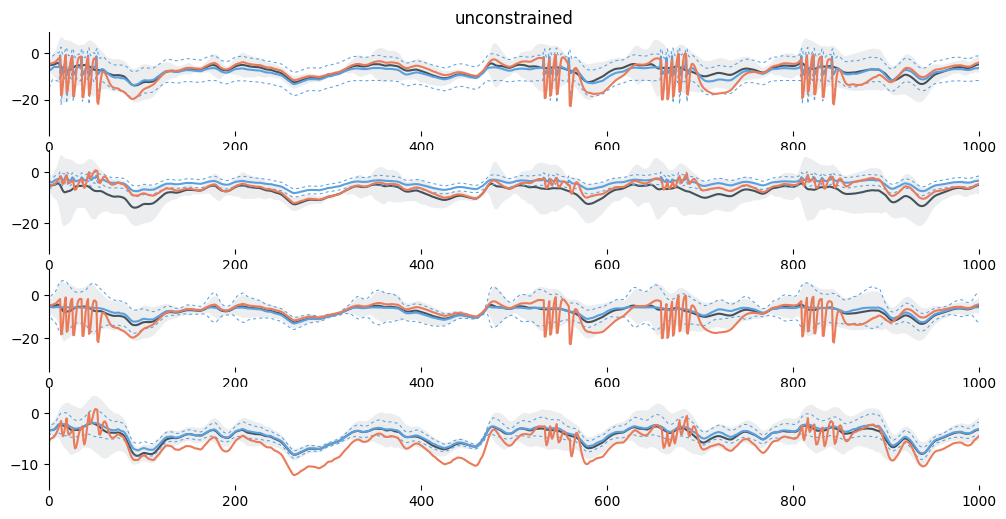

In [36]:
NSHOW = 1000

subplot(411)
fallLR,fallLV,fallM1,fallM2,nll = filter_moments(stim[:NFILT],Y[:NFILT],A,beta,C,m,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5,
                                     reg_cov     = 0.001)
logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(fallLR,fallLV,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr,color=RUST)
simpleraxis()
title('unconstrained')

subplot(412)
fallLR,fallLV,fallM1,fallM2,nll = filter_moments(stim2[:NFILT],Y[:NFILT],A,beta2,C,m2,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5,
                                     reg_cov     = 0.001)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(fallLR,fallLV,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr2,color=RUST)
simpleraxis()

# Unconstrained filtering
subplot(413)
fallLR,fallLV,fallM1,fallM2 = integrate_moments(stim[:NFILT],A,beta,C,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(fallLR,fallLV,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr,color=RUST)
simpleraxis()

# Unconstrained filtering
subplot(414)
logxso2,logvso2,fallM1,fallM2 = integrate_moments(stim2[:NFILT],A,beta2,C,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5)
stderrplot(lxpp2,lvpp2,BLACK,filled=1)
stderrplot(logxso2,logvso2,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr2,color=RUST)
simpleraxis()

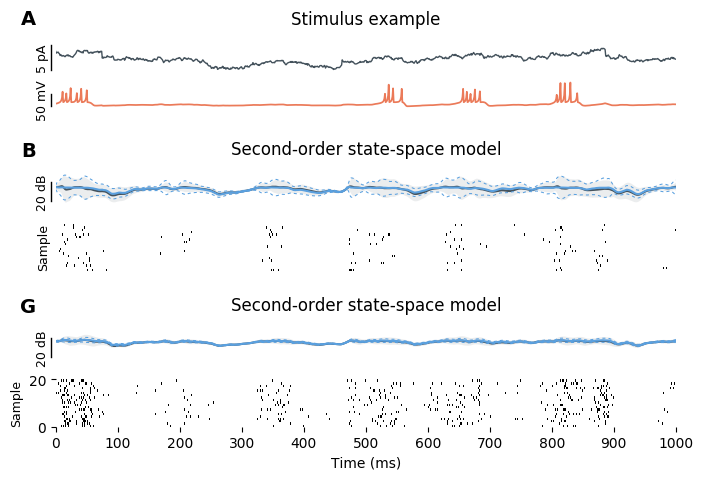

In [37]:
figure(figsize=(8,13))

sc = 20
ax4=subplot2grid((NROWS,2),(2,0),colspan=2,facecolor=(1,1,1,0))
plot(V,color=RUST,lw=1.25)
xlim(0,NSHOW);
yscalebar(min(V)+25,50,'50 mV')
offset = -min(stimulus*sc) + ylim()[1]+30
ss = stimulus*sc + offset
plot(ss,color=BLACK,lw=1)
yscalebar(mean(ss),sc*5,'5 pA'); 
noxyaxes()
title('Stimulus example')
subfigurelabel('A')

yl = (-40,20)

# Plot stimulus
ax5=subplot2grid((NROWS,2),(3,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(logxso,logvso,AZURE,filled=0)
xlim(0,NSHOW); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Second-order state-space model')
subfigurelabel('B')

# Plot sampled from single-time marginals (no time correlation)
ax6=subplot2grid((NROWS,2),(4,0),colspan=2,facecolor=(1,1,1,0))
rate = exp(logxso)*(1+0.5*logvso)
p = np.random.poisson(rate[:,None],(len(rate),nsamp))
pcolormesh(-int32(p.T>0),cmap='gray')
noxyaxes();  xlim(0,NSHOW);
ylabel('Sample',fontsize=9); 

# Plot stimulus
ax7=subplot2grid((NROWS,2),(5,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp2,lvpp2,BLACK,filled=1)
stderrplot(logxso2,logvso2,AZURE,filled=0)
xlim(0,NSHOW); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Second-order state-space model')
subfigurelabel('G')

# Plot sampled from single-time marginals (no time correlation)
ax8=subplot2grid((NROWS,2),(6,0),colspan=2,facecolor=(1,1,1,0))
rate = exp(logxso2)*(1+0.5*logvso2)
p = np.random.poisson(rate[:,None],(len(rate),nsamp))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); xticks(arange(0,1001,100)); xlim(0,NSHOW);
xlabel('Time (ms)'); ylabel('Sample',fontsize=9); 


# Adjust axes
subplots_adjust(wspace=0.1,hspace=0.3)
nudge_axis_y(-75,ax4)
adjust_axis_height_pixels(20,ax5)
nudge_axis_y(-85,ax5)
adjust_axis_height_pixels(30,ax6)
nudge_axis_y(-35,ax6)
adjust_axis_height_pixels(20,ax7)
nudge_axis_y(-40,ax7)
adjust_axis_height_pixels(30,ax8)
nudge_axis_y(10,ax8)

# Problems!

Optimization is WAY too slow. There's also something wrong (excessive biase toward high rates). But to figure out what's wrong, we need a faster update!

# The surrogate method

In [27]:
from arppglm import *
from measurements import *
from utilities import *
from arguments import *

In [28]:
def filter_moments_surrogate(stim,Y,A,beta,C,m,
    dt          = 1.0,
    oversample  = 10,
    maxrate     = 500,
    maxvcorr    = 2000,
    method      = "moment_closure",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = 0.01,
    reg_rate    = 0.001,
    return_surrogates = True,
    surrogates        = None):
    # check arguments
    if oversample<1:
        raise ValueError('oversample must be non-negative integer')
    if return_surrogates and not surrogates is None:
        raise ValueError('Asked to compute surrogate likelihoods, but surrogates provided?')
    if not return_surrogates and surrogates is None:
        raise ValueError('No surrogate likelihoods provided?')
    # Precompute constants
    maxlogr   = np.log(maxrate)
    maxratemc = maxvcorr*maxrate
    dtfine    = dt/oversample
    T         = len(stim)
    K         = beta.size
    I         = np.eye(K)
    Cb        = C.dot(beta.T)
    CC        = C.dot(C.T)
    BB        = beta.dot(beta.T)
    Adt       = A*dtfine
    # Get measurement update function
    measurement            = get_measurement(measurement)
    mean_update,cov_update = get_moment_integrator(int_method,Adt)
    update                 = get_update_function(method,Cb,Adt,maxvcorr)
    # accumulate negative log-likelihood up to a constant
    nll = 0
    llrescale = 1.0/len(stim)
    # Store surrogate likelihoods
    if return_surrogates:
        surrogates = np.zeros((T,2))
    # Initial condition for moments
    M1 = pinv(beta,m).reshape((K,1))
    M2 = np.eye(K)*1e-2
    for i,s in enumerate(stim):
        # Integrate moments forward
        for j in range(oversample):
            logv  = beta.T.dot(M2).dot(beta)
            logx  = min(beta.T.dot(M1)+s,maxlogr)
            R0    = sexp(logx)*dtfine
            Rm,J  = update(logx,logv,R0,M1,M2)
            M2    = cov_update(M2,J) + CC*Rm
            M1    = mean_update(M1)  + C*Rm
        # Measurement update
        pM1,pM2 = M1,M2
        # If computing surrogates, requenst and store them
        if return_surrogates:
            M1,M2,ll,(mr,tr) = measurement_update_projected_gaussian_surrogate(\
                      M1,M2,Y[i],beta,s,dt,m,reg_rate,measurement,
                      return_surrogate=True)
            surrogates[i] = mr,tr
        # Otherwise, pass precomputed surrogate likelihood for update
        else:
            mr,tr = surrogates[i]
            M1,M2,ll = measurement_update_projected_gaussian_surrogate(\
                      M1,M2,Y[i],beta,s,dt,m,reg_rate,measurement,
                      surrogate=(mr, tr))
        nll -= ll*llrescale
        
        # Regularize
        strength = reg_cov+max(0,-np.min(np.diag(M2)))
        M2 = 0.5*(M2+M2.T) + strength*np.eye(K) 
        # Store moments
        allM1[i] = M1[:,0].copy()
        allM2[i] = M2.copy()
        allLR[i] = beta.T.dot(M1)+s
        allLV[i] = beta.T.dot(M2).dot(beta)
        
        # Heuristic: detect numerical failure and exit early
        failed = False
        failed|= np.any(M1)<-1e5
        failed|= logx>100*maxlogr
        failed|= nll<-1e10
        if failed:
            nll = inf
            break
    if return_surrogates:
        return allLR,allLV,allM1,allM2,nll,surrogates
    else:
        return allLR,allLV,allM1,allM2,nll

In [29]:
def filter_likelihood_surrogate(stim,Y,A,beta,C,m,
    dt          = 1.0,
    oversample  = 10,
    maxrate     = 500,
    maxvcorr    = 2000,
    method      = "moment_closure",
    int_method  = "euler",
    measurement = "moment",
    reg_cov     = 0.01,
    reg_rate    = 0.001,
    surrogates  = None):
    assert surrogates is not none
    # Precompute constants
    maxlogr   = np.log(maxrate)
    maxratemc = maxvcorr*maxrate
    dtfine    = dt/oversample
    T         = len(stim)
    K         = beta.size
    I         = np.eye(K)
    Cb        = C.dot(beta.T)
    CC        = C.dot(C.T)
    BB        = beta.dot(beta.T)
    Adt       = A*dtfine
    # Get measurement update function
    measurement = get_measurement(measurement)
    # Buid moment integrator functions
    mean_update, cov_update = get_moment_integrator(int_method,Adt)
    # Get update function (computes expected rate from moments)
    update = get_update_function(method,Cb,Adt,maxvcorr)
    # accumulate negative log-likelihood up to a constant
    nll = 0
    llrescale = 1.0/len(stim)
    # Store moments
    allM1 = np.zeros((T,K))
    allM2 = np.zeros((T,K,K))
    allLR = np.zeros((T))
    allLV = np.zeros((T))
    # Store surrogate likelihoods
    if return_surrogates:
        surrogates = np.zeros((T,2))
    # Initial condition for moments
    M1 = pinv(beta,m).reshape((K,1))
    M2 = np.eye(K)*1e-2
    for i,s in enumerate(stim):
        # Regularize
        M2 = 0.5*(M2+M2.T)+(reg_cov+max(0,-np.min(np.diag(M2))))*I
        # Integrate moments forward
        for j in range(oversample):
            logv  = beta.T.dot(M2).dot(beta)
            logx  = min(beta.T.dot(M1)+s,maxlogr)
            R0    = sexp(logx)*dtfine
            Rm,J  = update(logx,logv,R0,M1,M2)
            M2    = cov_update(M2,J) + CC*Rm
            M1    = mean_update(M1)  + C*Rm
        # Measurement update
        mr,tr    = surrogates[i]
        M1,M2,ll = measurement_update_projected_gaussian_surrogate(\
                  M1,M2,Y[i],beta,s,dt,m,reg_rate,measurement,
                  surrogate=(mr, tr))
        nll -= ll*llrescale
        # Heuristic: detect numerical failure and exit early
        failed = False
        failed|= np.any(M1)<-1e5
        failed|= logx>100*maxlogr
        failed|= nll<-1e10
        if failed:
            nll = inf
            break
    return nll

### Test it!

In [30]:
measurement = "moment"
method      = "second_order"
int_method  = "euler"
oversample  = 4
showplot    = False

p0 = np.zeros((1+K))
p0[0 ] = m
p0[1:] = beta.ravel()

tic()
LR,LV,M1,M2,nll,surrogates = filter_moments_surrogate(stim[:NFILT],Y[:NFILT],A,beta,C,m,
                                 method      = method,
                                 int_method  = int_method,
                                 measurement = measurement,
                                 oversample  = oversample,
                                 reg_cov     = 0.0001,
                                 reg_rate    = 0.0001,
                                 return_surrogates = True)
toc()
print(nll)
subplot(311)
logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
stderrplot(LR,LV,BLACK,filled=1,lw=0.5)
xlim(0,NFILT);
plot(logr,color=RUST,lw=0.5)
simpleraxis()
title('With measurements')

tic()
LR,LV,M1,M2,nll = filter_moments_surrogate(stim[:NFILT],Y[:NFILT],A,beta,C,m,
                                 method      = method,
                                 int_method  = int_method,
                                 measurement = measurement,
                                 oversample  = oversample,
                                 reg_cov     = 0.0001,
                                 reg_rate    = 0.0001,
                                 return_surrogates = False,
                                 surrogates  = surrogates)
toc()
print(nll)
subplot(312)
logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
stderrplot(LR,LV,BLACK,filled=1,lw=0.5)
xlim(0,NFILT);
plot(logr,color=RUST,lw=0.5)
simpleraxis()
title('Surrogate measurements')


tic()
fallLR,fallLV,fallM1,fallM2 = integrate_moments(stim[:NFILT],A,beta,C,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 4)
toc()
print(nll)
subplot(313)
logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
stderrplot(fallLR,fallLV,BLACK,filled=1,lw=0.5)
xlim(0,NFILT);
plot(logr,color=RUST,lw=0.5)
simpleraxis()
title('No measurements')


t=4072420ms 


NameError: name 'allM1' is not defined

In [ ]:
baseline_m = m

def objective(parameters):
    # parameters encode beta,m
    parameters = parameters.ravel()
    
    m    = parameters[0]
    beta = parameters[1:].reshape((K,1))
    
    
    
    # Get likelihood by filtering
    try:
        LR,LV,M1,M2,nll = filter_moments_surrogate(\
                                                   stim[:NFILT]*exp(m-baseline_m),
                                                   Y[:NFILT],
                                                   A,beta,C,m,
                                 method      = method,
                                 int_method  = int_method,
                                 measurement = measurement,
                                 oversample  = oversample,
                                 reg_cov     = 0.0001,
                                 reg_rate    = 0.0001,
                                 return_surrogates = False,
                                 surrogates  = surrogates)
    except (KeyboardInterrupt, SystemExit): 
        raise
    except:
        traceback.print_exc()
        nll = inf
    
    print(nll,'['+','.join(['%0.6f'%x for x in parameters])+']')
    return nll

# Some previous optimization results; might want to start here 

#p0 = [-5.4441,13.6292,-31.0732,27.3024,-11.8203,3.8410,-2.1191,0.7272,-0.7314]
#p0 = [-5.100000,12.778247,-32.342192,27.684731,-9.483315,4.797808,-5.698736,0.864248,-0.875519]
#p0 = [-5.100000,-3.002729,-7.387821,8.540159,-4.402787,6.953274,-7.052284,1.343207,-0.807306]
#p0 = [-5.1000,-3.0345,-7.4832,8.3815,-4.5722,6.8364,-7.0031,1.5097,-0.7121]
#p0 = [-5.1000,-16.8451,-10.9591,13.9213,-4.8764,4.8806,-2.8319,-2.6813,-0.6895]
#p0  = [-6.8267,-14.5113,-12.2582,19.8257,-11.3998,9.4435,-4.5493,-0.8425,0.1381]
#p0 = [-6.8034,-14.4812,-12.2502,19.8148,-11.4017,9.4339,-4.5452,-0.8094,0.1385]
#p0 = [-6.8034,-14.5821,-12.4526,19.5295,-11.7096,9.0415,-4.9698,-1.2497,-0.5224]
#p0 = [-6.8034,-14.5827,-12.4544,19.5262,-11.4234,9.3272,-4.9632,-1.7242,-1.3170]
#p0 = [-6.5234,-16.2560,-12.9578,19.2764,-10.9165,9.2419,-4.7980,-1.7083,-1.2991]
#p0 = [-6.7323,-16.3787,-12.8744,19.2316,-11.1853,8.9326,-4.8782,-1.8222,-1.2926]
#p0 = [-6.7324,-16.3787,-12.8744,19.2314,-11.1853,8.9325,-4.8782,-1.8223,-1.2927]
#p0 = [-6.4118,-16.3787,-12.8744,19.2314,-11.1853,8.9325,-4.8782,-1.8223,-1.2927]
#p0 = [-5.9985,-18.8823,-12.7941,19.2112,-10.6532,8.0912,-4.7045,-2.1577,-1.2712]

parameters = minimize_retry(objective,p0)
print('['+','.join(['%0.4f'%x for x in parameters])+']')

# Inspect dynamics of new model

In [ ]:
#parameters = [-6.8034,-14.5821,-12.4526,19.5295,-11.7096,9.0415,-4.9698,-1.2497,-0.5224]

# Get new parameters from optimization
parameters = array(parameters)
m2         = parameters[0]-0.5
beta2      = parameters[1:].reshape((K,1))
logr2      = m2 + bhat_stimulus.dot(demo_Bh.T) + (beta2.T.dot(demo_By.T))[0]

stim2 = stim*exp(m2-m)
# "True" sample from new point process model
logxpp2,logvpp2,ratepp2,ratevpp2 = ensemble_sample_moments(stim2,B,beta2,M=1000)
lxpp2 = box_filter(logxpp2,5)
lvpp2 = box_filter(logvpp2,5)

In [ ]:
NSHOW = 1000

subplot(411)
fallLR,fallLV,fallM1,fallM2,nll = filter_moments(stim[:NFILT],Y[:NFILT],A,beta,C,m,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5,
                                     reg_cov     = 0.001)
logr = m + bhat_stimulus.dot(demo_Bh.T) + bhat_spikehist.dot(demo_By.T)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(fallLR,fallLV,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr,color=RUST)
simpleraxis()
title('unconstrained')

subplot(412)
fallLR,fallLV,fallM1,fallM2,nll = filter_moments(stim2[:NFILT],Y[:NFILT],A,beta2,C,m2,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5,
                                     reg_cov     = 0.001)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(fallLR,fallLV,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr2,color=RUST)
simpleraxis()

# Unconstrained filtering
subplot(413)
fallLR,fallLV,fallM1,fallM2 = integrate_moments(stim[:NFILT],A,beta,C,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5)
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(fallLR,fallLV,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr,color=RUST)
simpleraxis()

# Unconstrained filtering
subplot(414)
logxso2,logvso2,fallM1,fallM2 = integrate_moments(stim2[:NFILT],A,beta2,C,
                                     method      = "second_order",
                                     int_method  = "euler",
                                     oversample  = 5)
stderrplot(lxpp2,lvpp2,BLACK,filled=1)
stderrplot(logxso2,logvso2,AZURE,filled=0)
xlim(0,NSHOW);
plot(logr,color=RUST)
simpleraxis()

In [ ]:
figure(figsize=(8,13))

sc = 20
ax4=subplot2grid((NROWS,2),(2,0),colspan=2,facecolor=(1,1,1,0))
plot(V,color=RUST,lw=1.25)
xlim(0,NSHOW);
yscalebar(min(V)+25,50,'50 mV')
offset = -min(stimulus*sc) + ylim()[1]+30
ss = stimulus*sc + offset
plot(ss,color=BLACK,lw=1)
yscalebar(mean(ss),sc*5,'5 pA'); 
noxyaxes()
title('Stimulus example')
subfigurelabel('A')

yl = (-40,20)

# Plot stimulus
ax5=subplot2grid((NROWS,2),(3,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(logxso,logvso,AZURE,filled=0)
xlim(0,NSHOW); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Second-order state-space model')
subfigurelabel('B')

# Plot sampled from single-time marginals (no time correlation)
ax6=subplot2grid((NROWS,2),(4,0),colspan=2,facecolor=(1,1,1,0))
rate = exp(logxso)*(1+0.5*logvso)
p = np.random.poisson(rate[:,None],(len(rate),nsamp))
pcolormesh(-int32(p.T>0),cmap='gray')
noxyaxes();  xlim(0,NSHOW);
ylabel('Sample',fontsize=9); 

# Plot stimulus
ax7=subplot2grid((NROWS,2),(5,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp2,lvpp2,BLACK,filled=1)
stderrplot(logxso2,logvso2,AZURE,filled=0)
xlim(0,NSHOW); ylim(*yl); yscalebar(mean(ylim()),20,'20 dB'); noxyaxes(); 
title('Second-order state-space model')
subfigurelabel('G')

# Plot sampled from single-time marginals (no time correlation)
ax8=subplot2grid((NROWS,2),(6,0),colspan=2,facecolor=(1,1,1,0))
rate = exp(logxso2)*(1+0.5*logvso2)
p = np.random.poisson(rate[:,None],(len(rate),nsamp))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); xticks(arange(0,1001,100)); xlim(0,NSHOW);
xlabel('Time (ms)'); ylabel('Sample',fontsize=9); 


# Adjust axes
subplots_adjust(wspace=0.1,hspace=0.3)
nudge_axis_y(-75,ax4)
adjust_axis_height_pixels(20,ax5)
nudge_axis_y(-85,ax5)
adjust_axis_height_pixels(30,ax6)
nudge_axis_y(-35,ax6)
adjust_axis_height_pixels(20,ax7)
nudge_axis_y(-40,ax7)
adjust_axis_height_pixels(30,ax8)
nudge_axis_y(10,ax8)

# Derivation of variational update

Match a multivariate Gaussian to the true measurement posterior using variational Bayes: minimize the KL divergence from the approximating to the true distribution.

$$
\Pr(x) = \left\lvert 2\pi\Sigma \right\rvert ^{-\frac 1 2} \exp\left({-\frac 1 2 (x-\mu)^\top \Sigma ^{-1} (x-\mu)}\right)
$$

The observation model is Poisson 

$$
\Pr(y|x) = \frac 1 {y!} \lambda^y e^{-\lambda}
$$

$$
\ln\lambda = \beta^\top x + I(t)
$$

For a variational update, we minimize

$$
D_{KL}( Q \| \Pr(x|y) ) = 
\int_x Q(x) \ln \frac {Q(x)} {\Pr(x|y)} = \left< \ln \frac {Q(x)} {\Pr(x|y)} \right>_Q
$$

Where $Q(x)$ is the approximating variational posterior, which we will take to be multivariate normal $Q(x) \sim \mathcal{N}(\tilde\mu,\tilde\Sigma)$.


Since $\Pr(x|y) \propto \Pr(y|x) P(x)$, we can minimize $D_{KL}$ by minimizing

$$
\left< \ln \frac {Q(x) } {\Pr(y|x)  {\Pr(x)}  }
\right>_Q
$$

The prior and the likelihood can be separated, and we can focus on minimizing

$$
D_{KL}\left( Q \| P \right)
-
\left< \ln \Pr(y|x) \right>_Q
$$

The $D_{KL}\left( Q \| P \right)$ between two Gaussian has the form

$$
D_{KL}\left( Q \| P \right) = 
\frac 1 2 \left[tr( \Sigma^{-1} \tilde\Sigma )
+ (\mu - \tilde\mu)^\top \Sigma^{-1} (\mu - \tilde\mu)
+ \ln \frac {|\Sigma|}{|\tilde\Sigma|}
\right] + \text{constant}
$$

Consider then the second term, $\left< \ln \Pr(y|x) \right>_Q$

$$
\ln\Pr(y|x) = -\ln y! + y \ln \lambda - \lambda
$$

For the purposes of optimizing the posterior, $-\ln y!$ is constant and can be ignored. Any terms here that do not depend on $x$ can be dropped as they are consant with respect to optimizing the posterior. Taking expectation over $Q$, we get

$$
\left<\ln\Pr(y|x)\right>_Q = 
y \beta^\top \tilde\mu - \left< \lambda \right>_Q + \text{constant}
$$

The expectation $\left< \lambda \right>_Q$ looks familiar! It is the same expectation that we use for estimating $\left<\lambda\right>$ in the moment closure, and we can use the same approximation for evaluating it, this time at the variational posterior $Q$. 

$$
\left< \lambda \right>_Q = \exp\left( 
\beta^\top \tilde\mu + I(t) + \tfrac 1 2 \beta^\top \tilde \Sigma \beta
\right)
$$ 

Overall, we need to minimize

$$
\frac 1 2 \left[tr( \Sigma^{-1} \tilde\Sigma )
+ (\tilde\mu - \mu)^\top \Sigma^{-1} (\tilde\mu - \mu)
+ \ln \frac {|\Sigma|}{|\tilde\Sigma|}
\right]
-\left[
y \beta^\top \tilde\mu - \left< \lambda \right>_Q 
\right]
$$


The gradient in $\tilde\mu$ 

$$
\nabla_{\tilde\mu}
\left[\dots
\right] = 
\Sigma^{-1} (\tilde\mu - \mu)
+\left(\left< \lambda \right>_Q - y\right)\beta^\top
$$

The hessian in $\tilde\mu$

$$
\nabla^2_{\tilde\mu} = \Sigma^{-1} +  \text{diag}\left(\left<\lambda\right>_Q\beta^2\right)
$$

For fixed $\tilde\mu$, the optimal $\tilde\Sigma$ has the closed form (Zhao and Park 2016)



$$
\tilde\Sigma^{-1} = \Sigma^{-1} + \text{diag}\left( 
\left<\lambda\right>_Q \beta^2
\right)
$$

This provides a coordinate descent approach to obtaining the variational posterior

How to backpropagate across a non-conjugate update. 
For a non-conjugate update, we estimate

$$
Q(x) \approx P(x|y) = P(y|x) \frac {P(x)} {P(y)}
$$

Usually $Q(x)\sim\mathcal{N}(\hat\mu,\hat\Sigma)$ is multivariate Gaussian. We estimate the likelihood $P(y)$ as

$$
P(y) \approx \frac{P(y|x{=}\hat\mu)} {Q(x{=}\hat\mu)} P(x{=}\hat\mu)
$$

Or the log-likelihood

$$
\ln P(y) \approx \ln P(y|x{=}\hat\mu) - \ln Q(x{=}\hat\mu) + \ln P(x{=}\hat\mu)
$$

The likelihood and state-update are usually differentiable in parameters $\theta$. The derivative of the posterior, which is the solution to a minimization problem, is less clear. 

$$
\nabla_\theta \ln Q(x{=}\hat\mu)
$$

If $Q$ is Gaussian evaluated at its mean, then 

$$
\ln Q(x{=}\hat\mu) = -\frac 1 2 \left\lvert 2 \pi \hat \Sigma \right\rvert
$$

To backpropagate / chain rule, we need to know

$$
\nabla_\theta \left\lvert \hat \Sigma \right\rvert
$$


In [ ]:
det

In [ ]:
min_log = np.float32(2.5421149729252075e-23)
max_exp = 

In [44]:
sqrt(6.4623485355705285e-46)

2.5421149729252075e-23

In [ ]:
dtype = 'float32'

In [60]:
np.dtype.namedd

<attribute 'name' of 'numpy.dtype' objects>

In [53]:
np.finfo(np.dtype(dtype))

ValueError: data type <class 'numpy.object_'> not inexact

In [67]:
dtype='float32'
np.array([],dtype='float32').dtype

dtype('float32')

In [70]:
np.finfo(dtype).max

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [86]:
log(np.finfo(dtype).eps )

-15.942385

In [71]:
min_log = np.finfo(dtype).tiny
max_exp = np.log(np.sqrt(np.finfo(dtype).max))

44.36142

In [73]:
np.finfo(dtype)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [76]:

np.finfo(dtype).eps 

1.1920929e-07

In [77]:

np.finfo(dtype).tiny

1.1754944e-38

In [80]:
np.nextafter(np.array(0,dtype=dtype),1)

4.9406564584124654e-324

In [81]:
np.float32(4.9406564584124654e-324)

0.0